In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns

import os
import subprocess

import random as random
import scipy.stats as stats
import scipy as sci
import math as math

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
wt_fcy1 = 'ATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGGGTTACAAGGAAGGTGGTGTTCCAATCGGTGGTTGTTTGATCAACAACAAGGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGATTGGAAGGTAAGGTCTATAAGGACACCACCTTGTACACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCGTTGATGACGAAAGATGTAAGAAGATCATGAAGCAATTTATTGATGAACGTCCACAAGACTGGTTCGAAGATATTGGTGAA'
# Wild-type codon-optimized FCY1 sequence from start to last codon (no-stop)

In [3]:
codontable_standard = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',
    }

def translate_seq(seq):
    protein =''
    for i in range(0, len(seq), 3):
        codon = seq[i:i + 3]
        protein+= codontable_standard[codon]
    return protein

# simple function to translate coding sequences into protein

In [4]:
aa_to_codon = {}
# a dict to get all codons encoding each amino acid

for aa in codontable_standard.values():
    
    if aa not in aa_to_codon:
        aa_to_codon[aa] = []
        
        for key in codontable_standard.keys():
            if codontable_standard[key] == aa:
                aa_to_codon[aa] +=[key]
aa_to_codon

{'I': ['ATA', 'ATC', 'ATT'],
 'M': ['ATG'],
 'T': ['ACA', 'ACC', 'ACG', 'ACT'],
 'N': ['AAC', 'AAT'],
 'K': ['AAA', 'AAG'],
 'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'],
 'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'],
 'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'],
 'P': ['CCA', 'CCC', 'CCG', 'CCT'],
 'H': ['CAC', 'CAT'],
 'Q': ['CAA', 'CAG'],
 'V': ['GTA', 'GTC', 'GTG', 'GTT'],
 'A': ['GCA', 'GCC', 'GCG', 'GCT'],
 'D': ['GAC', 'GAT'],
 'E': ['GAA', 'GAG'],
 'G': ['GGA', 'GGC', 'GGG', 'GGT'],
 'F': ['TTC', 'TTT'],
 'Y': ['TAC', 'TAT'],
 '*': ['TAA', 'TAG', 'TGA'],
 'C': ['TGC', 'TGT'],
 'W': ['TGG']}

In [5]:
wt_prot = translate_seq(wt_fcy1)
wt_prot
# get wt Fcy1 protein sequence

'MVTGGMASKWDQKGMDIAYEEAALGYKEGGVPIGGCLINNKDGSVLGRGHNMRFQKGSATLHGEISTLENCGRLEGKVYKDTTLYTTLSPCDMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCKKIMKQFIDERPQDWFEDIGE'

In [6]:
def get_dict_of_seq(fasta_file):
    """ function that converts a fasta file to a dictionnary of sequences
    fasta_file: the input fasta file
    """
    
    file_fasta_dict = {}
    # output dict of imported seqs
    
    with open(fasta_file, 'r') as fasta:    
        for line in fasta:
            # loops through the file

            if line.startswith('>') == True:
                seq_info = line.strip('>').strip('\n').split('\t')[0]
                file_fasta_dict[seq_info] = ''
                # checks if seq header

            else:
                file_fasta_dict[seq_info] += line.strip('\n')
                # If not, append nt to current seq
                
    return file_fasta_dict

In [7]:
def get_n_reads_in_fastqgz(file):
    # get number of reads in a fastq file.
    
    
    call = 'zgrep -c \'@M028\' ./data/'+ file
    # Call to count the number of fastq headers
    
    n_reads = int(subprocess.check_output(call, shell=True).decode().strip('\n'))
    
    return n_reads
    
get_n_reads_in_fastqgz('10_S10_L001_R1_001.fastq.gz')

7330

In [8]:
def get_n_reads_in_fasta(file):
    # get number of reads in a fastq file (to count after pandaseq merging)
    
    seq_count = 0
    
    with open(file, 'r') as source:
        
        for line in source:
            if line.startswith('>'):
                seq_count+=1
                
    return seq_count

In [9]:
sample_df = pd.read_csv('./Miseq_dec2022_samples.csv', sep=',', index_col=0)
# import Miseq sample table as DataFrame
print(sample_df.head(96))

       i5_name    i5_seq i7_name    i7_seq
sample                                    
1         D501  TATAGCCT    D701  CGAGTAAT
2         D501  TATAGCCT    D702  TCTCCGGA
3         D501  TATAGCCT    D703  AATGAGCG
4         D501  TATAGCCT    D704  GGAATCTC
5         D501  TATAGCCT    D705  TTCTGAAT
...        ...       ...     ...       ...
92        D508  GTACTGAC    D708  GCGCATTA
93        D508  GTACTGAC    D709  CATAGCCG
94        D508  GTACTGAC    D710  TTCGCGGA
95        D508  GTACTGAC    D711  GCGCGAGA
96        D508  GTACTGAC    D712  CTATCGCT

[96 rows x 4 columns]


In [10]:
# map samples to specific plates and wells within plates, add file

plate_0N_dict = {}
plate_3N_dict = {}
# dict to store index:plate information

r1_file_dict = {}
r2_file_dict = {}
# dict to store index:filepath information

well_dict = {}
# dict to store index:well info

index=1

for plate in range(1,13):
    # iterate through plate pairs (one per cross)
    
    for x in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        # for row in plate
        for y in range(1,13):
            # for col in plate
            
            well_dict[index] = x+str(y)
            # store well info
            
            plate_0N_dict[index] = (2*plate)-1
            plate_3N_dict[index] = (2*plate)
            # store plate 0N and 3N info
            
            r1_file_dict[index] = str(index)+'_S'+str(index)+'_L001_R1_001.fastq.gz'
            r2_file_dict[index] = str(index)+'_S'+str(index)+'_L001_R2_001.fastq.gz'
            # store filepath info
            
            index +=1
            # increment index
        
sample_df['0N_plate'] = pd.Series(plate_0N_dict)
sample_df['3N_plate'] = pd.Series(plate_3N_dict)
sample_df['well'] = pd.Series(well_dict)
sample_df['r1_file'] = pd.Series(r1_file_dict)
sample_df['r2_file'] = pd.Series(r2_file_dict)
# add columns to DatFrame

In [11]:
sample_df

,i5_name,i5_seq,i7_name,i7_seq,0N_plate,3N_plate,well,r1_file,r2_file
sample,,,,,,,,,
1,D501,TATAGCCT,D701,CGAGTAAT,1,2,A1,1_S1_L001_R1_001.fastq.gz,1_S1_L001_R2_001.fastq.gz
2,D501,TATAGCCT,D702,TCTCCGGA,1,2,A2,2_S2_L001_R1_001.fastq.gz,2_S2_L001_R2_001.fastq.gz
3,D501,TATAGCCT,D703,AATGAGCG,1,2,A3,3_S3_L001_R1_001.fastq.gz,3_S3_L001_R2_001.fastq.gz
4,D501,TATAGCCT,D704,GGAATCTC,1,2,A4,4_S4_L001_R1_001.fastq.gz,4_S4_L001_R2_001.fastq.gz
5,D501,TATAGCCT,D705,TTCTGAAT,1,2,A5,5_S5_L001_R1_001.fastq.gz,5_S5_L001_R2_001.fastq.gz
...,...,...,...,...,...,...,...,...,...
1148,B508,GTCAGTCA,B720,GGCAAGTT,23,24,H8,1148_S1148_L001_R1_001.fastq.gz,1148_S1148_L001_R2_001.fastq.gz
1149,B508,GTCAGTCA,B721,AAGCGACT,23,24,H9,1149_S1149_L001_R1_001.fastq.gz,1149_S1149_L001_R2_001.fastq.gz
1150,B508,GTCAGTCA,B722,GGATCTGA,23,24,H10,1150_S1150_L001_R1_001.fastq.gz,1150_S1150_L001_R2_001.fastq.gz


In [12]:
sample_df['n_reads_before_merge'] = sample_df.apply(lambda x: get_n_reads_in_fastqgz(x.r1_file), axis=1)
# add info on number of reads in the DataFrame

sample_df

,i5_name,i5_seq,i7_name,i7_seq,0N_plate,3N_plate,well,r1_file,r2_file,n_reads_before_merge
sample,,,,,,,,,,
1,D501,TATAGCCT,D701,CGAGTAAT,1,2,A1,1_S1_L001_R1_001.fastq.gz,1_S1_L001_R2_001.fastq.gz,10891
2,D501,TATAGCCT,D702,TCTCCGGA,1,2,A2,2_S2_L001_R1_001.fastq.gz,2_S2_L001_R2_001.fastq.gz,8239
3,D501,TATAGCCT,D703,AATGAGCG,1,2,A3,3_S3_L001_R1_001.fastq.gz,3_S3_L001_R2_001.fastq.gz,8244
4,D501,TATAGCCT,D704,GGAATCTC,1,2,A4,4_S4_L001_R1_001.fastq.gz,4_S4_L001_R2_001.fastq.gz,12722
5,D501,TATAGCCT,D705,TTCTGAAT,1,2,A5,5_S5_L001_R1_001.fastq.gz,5_S5_L001_R2_001.fastq.gz,7583
...,...,...,...,...,...,...,...,...,...,...
1148,B508,GTCAGTCA,B720,GGCAAGTT,23,24,H8,1148_S1148_L001_R1_001.fastq.gz,1148_S1148_L001_R2_001.fastq.gz,1198
1149,B508,GTCAGTCA,B721,AAGCGACT,23,24,H9,1149_S1149_L001_R1_001.fastq.gz,1149_S1149_L001_R2_001.fastq.gz,3756
1150,B508,GTCAGTCA,B722,GGATCTGA,23,24,H10,1150_S1150_L001_R1_001.fastq.gz,1150_S1150_L001_R2_001.fastq.gz,2983


In [13]:
random.seed(1)
# set random seed

for x in range(0,5):   
    lib = random.choice(range(1, 1152))
    # choose 5 random libraries for QC
    
    fastqc_line_r1 = 'fastqc ./data/'+str(lib)+'_S'+str(lib)+'_L001_R1_001.fastq.gz -o fastqc_reps'
    fastqc_line_r2 = 'fastqc ./data/'+str(lib)+'_S'+str(lib)+'_L001_R2_001.fastq.gz -o fastqc_reps'
        
    subprocess.check_output(fastqc_line_r1, shell=True)
    subprocess.check_output(fastqc_line_r2, shell=True)
    
    # run fastqc on randomly selected files, for R1 and R2. Can be commented out if it has already been run.

In [14]:
merged_path = {}
# store merged read filepath

for index in list(sample_df.index):
    # loop though samples
        
    path_R1, path_R2 = sample_df.loc[index]['r1_file'], sample_df.loc[index]['r2_file']
    # get filepaths 
    
    path_out = './merged/'+str(index)+'.fasta'
    merged_path[index] = path_out
    # make output path and store it
    
    panda_seq_call = 'pandaseq -f ./data/'
    panda_seq_call += path_R1
    panda_seq_call += ' -r ./data/' + path_R2
    panda_seq_call += ' -L 530 -l 500 -O 480 -k 4 -B -N -t 0.5 -T 6 '
    panda_seq_call += '-g ./logs/'+str(index)+'.fasta'
    panda_seq_call += ' -w ' + path_out
    # make pandaseq call
    
    #subprocess.check_output(panda_seq_call, shell=True)
    # run command, only needs to be done once. Then this line can be commented out

    
sample_df['merged_path'] = pd.Series(merged_path)
# add column to df

In [15]:
sample_df['n_reads_after_merge'] = sample_df.apply(lambda x: get_n_reads_in_fasta(x.merged_path), axis=1)
# add the number of reads after merging
sample_df

,i5_name,i5_seq,i7_name,i7_seq,0N_plate,3N_plate,well,r1_file,r2_file,n_reads_before_merge,merged_path,n_reads_after_merge
sample,,,,,,,,,,,,
1,D501,TATAGCCT,D701,CGAGTAAT,1,2,A1,1_S1_L001_R1_001.fastq.gz,1_S1_L001_R2_001.fastq.gz,10891,./merged/1.fasta,7142
2,D501,TATAGCCT,D702,TCTCCGGA,1,2,A2,2_S2_L001_R1_001.fastq.gz,2_S2_L001_R2_001.fastq.gz,8239,./merged/2.fasta,3737
3,D501,TATAGCCT,D703,AATGAGCG,1,2,A3,3_S3_L001_R1_001.fastq.gz,3_S3_L001_R2_001.fastq.gz,8244,./merged/3.fasta,4449
4,D501,TATAGCCT,D704,GGAATCTC,1,2,A4,4_S4_L001_R1_001.fastq.gz,4_S4_L001_R2_001.fastq.gz,12722,./merged/4.fasta,7037
5,D501,TATAGCCT,D705,TTCTGAAT,1,2,A5,5_S5_L001_R1_001.fastq.gz,5_S5_L001_R2_001.fastq.gz,7583,./merged/5.fasta,3794
...,...,...,...,...,...,...,...,...,...,...,...,...
1148,B508,GTCAGTCA,B720,GGCAAGTT,23,24,H8,1148_S1148_L001_R1_001.fastq.gz,1148_S1148_L001_R2_001.fastq.gz,1198,./merged/1148.fasta,69
1149,B508,GTCAGTCA,B721,AAGCGACT,23,24,H9,1149_S1149_L001_R1_001.fastq.gz,1149_S1149_L001_R2_001.fastq.gz,3756,./merged/1149.fasta,991
1150,B508,GTCAGTCA,B722,GGATCTGA,23,24,H10,1150_S1150_L001_R1_001.fastq.gz,1150_S1150_L001_R2_001.fastq.gz,2983,./merged/1150.fasta,1030


In [16]:
sum(sample_df['n_reads_before_merge']), sum(sample_df['n_reads_after_merge'])
# check how many read pairs were filtered out

(9683086, 5351097)

## Split and aggregate merged reads: 3N amplicons

In [19]:

for index in list(sample_df.index):
    # loop though sample    
        
    merged_path = sample_df.loc[index]['merged_path']
    # get merged read path
    
    split_path = './split/'+str(index)+'_3N.fasta'
    # make 3N splir filepath
    
    
    vsearch_trim_call = 'vsearch --fastx_filter '
    vsearch_trim_call += merged_path
    vsearch_trim_call += ' --fastq_stripleft 24 --fastq_stripright 16 --fastq_maxlen 474 --fastq_minlen 474 --fastaout '
    vsearch_trim_call += split_path
    # make vsearch call for 3N oligos: trim primers and keep only sequences 474 bp long (FCY1 cds length)
    
    #subprocess.check_output(vsearch_trim_call, shell=True)
    # call trimming step. Then this line can be commented out
    
    agg_path = './aggregate/'+str(index)+'_3N_agg.fasta'
    # make aggregated sequences filepath
    
    
    vsearch_agg_call = 'vsearch --derep_fulllength '
    vsearch_agg_call += split_path
    vsearch_agg_call += ' --relabel seq --output '
    vsearch_agg_call += agg_path
    vsearch_agg_call += ' --sizeout'
    # make vsearch call for read aggregation at 100% identity
    
    #subprocess.check_output(vsearch_agg_call, shell=True)
    # call aggregation step, only needs to be done once
    


## Split and aggregate merged reads: 0N amplicons

In [20]:

for index in list(sample_df.index):
    # loop though sample      
    
    merged_path = sample_df.loc[index]['merged_path']
    # get merged read path
    
    split_path = './split/'+str(index)+'_0N.fasta'
    # make 3N splir filepath
    
    vsearch_trim_call = 'vsearch --fastx_filter '
    vsearch_trim_call += merged_path
    vsearch_trim_call += ' --fastq_stripleft 21 --fastq_stripright 13 --fastq_maxlen 474 --fastq_minlen 474 --fastaout '
    vsearch_trim_call += split_path
    # make vsearch call for 0N oligos: trim primers and keep only sequences 474 bp long (FCY1 cds length)
    
    #subprocess.check_output(vsearch_trim_call, shell=True)
    # call trimming step, only needs to be done once
    
    agg_path = './aggregate/'+str(index)+'_0N_agg.fasta'
    # make aggregated sequences filepath
    
    vsearch_agg_call = 'vsearch --derep_fulllength '
    vsearch_agg_call += split_path
    vsearch_agg_call += ' --relabel seq --output '
    vsearch_agg_call += agg_path
    vsearch_agg_call += ' --sizeout'
    # make vsearch call for read aggregation at 100% identity
    
    #subprocess.check_output(vsearch_agg_call, shell=True)
    # call aggregation step, only needs to be done once

In [21]:
sample_df

,i5_name,i5_seq,i7_name,i7_seq,0N_plate,3N_plate,well,r1_file,r2_file,n_reads_before_merge,merged_path,n_reads_after_merge
sample,,,,,,,,,,,,
1,D501,TATAGCCT,D701,CGAGTAAT,1,2,A1,1_S1_L001_R1_001.fastq.gz,1_S1_L001_R2_001.fastq.gz,10891,./merged/1.fasta,7142
2,D501,TATAGCCT,D702,TCTCCGGA,1,2,A2,2_S2_L001_R1_001.fastq.gz,2_S2_L001_R2_001.fastq.gz,8239,./merged/2.fasta,3737
3,D501,TATAGCCT,D703,AATGAGCG,1,2,A3,3_S3_L001_R1_001.fastq.gz,3_S3_L001_R2_001.fastq.gz,8244,./merged/3.fasta,4449
4,D501,TATAGCCT,D704,GGAATCTC,1,2,A4,4_S4_L001_R1_001.fastq.gz,4_S4_L001_R2_001.fastq.gz,12722,./merged/4.fasta,7037
5,D501,TATAGCCT,D705,TTCTGAAT,1,2,A5,5_S5_L001_R1_001.fastq.gz,5_S5_L001_R2_001.fastq.gz,7583,./merged/5.fasta,3794
...,...,...,...,...,...,...,...,...,...,...,...,...
1148,B508,GTCAGTCA,B720,GGCAAGTT,23,24,H8,1148_S1148_L001_R1_001.fastq.gz,1148_S1148_L001_R2_001.fastq.gz,1198,./merged/1148.fasta,69
1149,B508,GTCAGTCA,B721,AAGCGACT,23,24,H9,1149_S1149_L001_R1_001.fastq.gz,1149_S1149_L001_R2_001.fastq.gz,3756,./merged/1149.fasta,991
1150,B508,GTCAGTCA,B722,GGATCTGA,23,24,H10,1150_S1150_L001_R1_001.fastq.gz,1150_S1150_L001_R2_001.fastq.gz,2983,./merged/1150.fasta,1030


In [22]:
plate_dict = {}
well_dict = {}
file_dict = {}
i5_index_dict={}
i7_index_dict={}
# dicts that will store column information

index_sample=0
# set index counter to 0

for index in list(sample_df.index):
    # iterate through each pair of plates
    
    info_0N = sample_df.loc[index]['0N_plate'], sample_df.loc[index]['well']
    info_3N = sample_df.loc[index]['3N_plate'], sample_df.loc[index]['well']
    # extract 0N and 3N specific information
    
    nextera_indexes = sample_df.loc[index]['i5_name'], sample_df.loc[index]['i7_name']
    # get nextera indexes
    
    plate_dict[index_sample] = info_0N[0]
    well_dict[index_sample] = info_0N[1]
    file_dict[index_sample] = str(index)+'_0N_agg.fasta'
    i5_index_dict[index_sample]= nextera_indexes[0]
    i7_index_dict[index_sample]= nextera_indexes[1]
    # store plate, well, file and index info for 0N sample
    
    
    index_sample+=1
    # increment index
    
    plate_dict[index_sample] = info_3N[0]
    well_dict[index_sample] = info_3N[1]
    file_dict[index_sample] = str(index)+'_3N_agg.fasta'
    i5_index_dict[index_sample]= nextera_indexes[0]
    i7_index_dict[index_sample]= nextera_indexes[1]
    # store plate, well, file and index info for 3N sample
    
    index_sample+=1
    # increment index
    

mutant_df = pd.concat([pd.Series(plate_dict, name='plate'), pd.Series(well_dict, name='well'), pd.Series(file_dict, name='file')], axis=1)
mutant_df['i5_index'] = pd.Series(i5_index_dict)
mutant_df['i7_index'] = pd.Series(i7_index_dict)
# make DataFrame for all isolated colonies and add columns

In [23]:
mutant_df

,plate,well,file,i5_index,i7_index
0,1,A1,1_0N_agg.fasta,D501,D701
1,2,A1,1_3N_agg.fasta,D501,D701
2,1,A2,2_0N_agg.fasta,D501,D702
3,2,A2,2_3N_agg.fasta,D501,D702
4,1,A3,3_0N_agg.fasta,D501,D703
...,...,...,...,...,...
2299,24,H10,1150_3N_agg.fasta,B508,B722
2300,23,H11,1151_0N_agg.fasta,B508,B723
2301,24,H11,1151_3N_agg.fasta,B508,B723
2302,23,H12,1152_0N_agg.fasta,B508,B724


In [24]:
def get_total_read_count(file):
    # calculate the  number of reads passing length filters for each sample
    
    sequences_dict = get_dict_of_seq('./aggregate/'+file)
    
    n_reads = 0
    
    for header in sequences_dict.keys():
        
        n_occurences = int(header.split(';')[1].strip('size='))
        
        n_reads+=n_occurences
    
    return n_reads
    
    
get_total_read_count('1_0N_agg.fasta')

1031

In [25]:
mutant_df['total_read_count'] = mutant_df.apply(lambda x: get_total_read_count(x.file), axis=1)

mutant_df

,plate,well,file,i5_index,i7_index,total_read_count
0,1,A1,1_0N_agg.fasta,D501,D701,1031
1,2,A1,1_3N_agg.fasta,D501,D701,5812
2,1,A2,2_0N_agg.fasta,D501,D702,1038
3,2,A2,2_3N_agg.fasta,D501,D702,2507
4,1,A3,3_0N_agg.fasta,D501,D703,1300
...,...,...,...,...,...,...
2299,24,H10,1150_3N_agg.fasta,B508,B722,537
2300,23,H11,1151_0N_agg.fasta,B508,B723,70
2301,24,H11,1151_3N_agg.fasta,B508,B723,31
2302,23,H12,1152_0N_agg.fasta,B508,B724,40


1802.5


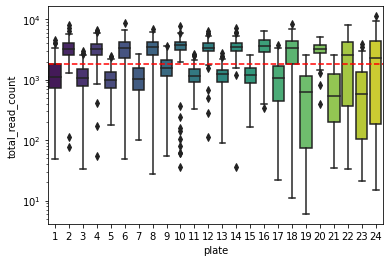

In [26]:
sns.boxplot(data = mutant_df, x='plate', y='total_read_count', palette='viridis')
plt.yscale('log')
plt.axhline(np.median(mutant_df['total_read_count']), color='red', linestyle='--')
print(np.median(mutant_df['total_read_count']))
# visualize the numebr of distribution of number of read pairs passing filter per sample for each plate

In [30]:
min_read_count = mutant_df['total_read_count'] > 251
len(mutant_df[min_read_count])
# Create filter for minimum read count 

2094

## Identify mutations
This loop will identify the top 6 genotypes in each sample and report the AA mutations, the mutant codon (s), and the number of reads for this genotype

In [40]:
seq1_mut = {}
seq1_codon = {}
seq1_count = {}

seq2_mut = {}
seq2_codon = {}
seq2_count = {}

seq3_mut = {}
seq3_codon = {}
seq3_count = {}

seq4_mut = {}
seq4_codon = {}
seq4_count = {}

seq5_mut = {}
seq5_codon = {}
seq5_count = {}

seq6_mut = {}
seq6_codon = {}
seq6_count = {}
# dictionnaries for the top 6 genotypes

for index in mutant_df.index:
    # loop through samples
    
    seq_dict = get_dict_of_seq('./aggregate/'+mutant_df.loc[index]['file'])
    top_seqs = [x for x in seq_dict.keys() if 'seq1;' in x or 'seq2;' in x or 'seq3;' in x or 'seq4;' in x or 'seq5;' in x or 'seq6;' in x]   
    seq_counts = [int(x.split(';')[1].strip('size=')) for x in top_seqs]
    # retrieve aggregated reads and get the top 6 sequences, as well as the number of reads
    
    
    diff_list_of_list = []
    codon_diff_list_of_list = []
    # empty container lists
    
    for seq in top_seqs:
        
        mut_seq = seq_dict[seq]
        prot_seq = translate_seq(mut_seq)
        # get mutant seq and translate it

        diff_list = []
        diff_codon_list = []
        # empty container lists

        for x in range(0,158):
            aa_wt = wt_prot[x]
            aa_seq = prot_seq[x]
            # loop through the FCY1 coding sequence

            if aa_wt != aa_seq:
                mut = aa_wt+str(x+1)+aa_seq
                diff_list.append(mut)
                diff_codon_list.append(mut_seq[(x*3):(x+1)*3])
                # if a mutation is found, add it to the list
                
                
        diff_list_of_list.append(diff_list)
        codon_diff_list_of_list.append(diff_codon_list)
        # append lists with info

    seq1_count[index], seq1_mut[index], seq1_codon[index] = seq_counts[0], diff_list_of_list[0], codon_diff_list_of_list[0]
    seq2_count[index], seq2_mut[index], seq2_codon[index] = seq_counts[1], diff_list_of_list[1], codon_diff_list_of_list[1]
    seq3_count[index], seq3_mut[index], seq3_codon[index] = seq_counts[2], diff_list_of_list[2], codon_diff_list_of_list[2]
    seq4_count[index], seq4_mut[index], seq4_codon[index] = seq_counts[3], diff_list_of_list[3], codon_diff_list_of_list[3]
    seq5_count[index], seq5_mut[index], seq5_codon[index] = seq_counts[4], diff_list_of_list[4], codon_diff_list_of_list[4]
    seq6_count[index], seq6_mut[index], seq6_codon[index] = seq_counts[5], diff_list_of_list[5], codon_diff_list_of_list[5]
    # add info to container dictionnaries        
        
mutant_df['seq_1'] = pd.Series(seq1_mut)
mutant_df['seq_1_codons'] = pd.Series(seq1_codon)
mutant_df['seq_1_count'] = pd.Series(seq1_count)

mutant_df['seq_2'] = pd.Series(seq2_mut)
mutant_df['seq_2_codons'] = pd.Series(seq2_codon)
mutant_df['seq_2_count'] = pd.Series(seq2_count)

mutant_df['seq_3'] = pd.Series(seq3_mut)
mutant_df['seq_3_codons'] = pd.Series(seq3_codon)
mutant_df['seq_3_count'] = pd.Series(seq3_count)

mutant_df['seq_4'] = pd.Series(seq4_mut)
mutant_df['seq_4_codons'] = pd.Series(seq4_codon)
mutant_df['seq_4_count'] = pd.Series(seq4_count)

mutant_df['seq_5'] = pd.Series(seq5_mut)
mutant_df['seq_5_codons'] = pd.Series(seq5_codon)
mutant_df['seq_5_count'] = pd.Series(seq5_count)

mutant_df['seq_6'] = pd.Series(seq6_mut)
mutant_df['seq_6_codons'] = pd.Series(seq6_codon)
mutant_df['seq_6_count'] = pd.Series(seq6_count)
  
#update DataFrame

(array([2.00e+00, 3.01e+02, 1.47e+03, 3.98e+02, 8.00e+00, 8.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <BarContainer object of 10 artists>)

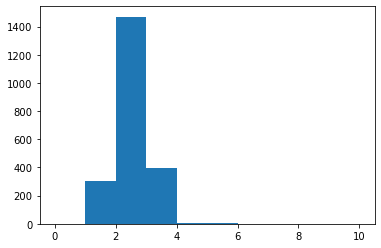

In [42]:
mutant_df['n_mut_seq_1'] = mutant_df.apply(lambda x: len(x.seq_1), axis=1)
mutant_df['n_mut_seq_2'] = mutant_df.apply(lambda x: len(x.seq_2), axis=1)
# make columns to quantify number of mutations in the top 2 most abundant genotypes in a sample

mutant_df['n_mut_top_2'] = mutant_df['n_mut_seq_1']+mutant_df['n_mut_seq_2']
# get total number of mutations the top 2 genotypes

In [43]:
no_wt = (mutant_df['n_mut_seq_1'] > 0) & (mutant_df['n_mut_seq_2'] > 0)
len(mutant_df[no_wt])
# make a filter for wild-type sequences

1989

In [44]:
low_mut_total = mutant_df['n_mut_top_2'] < 4
len(mutant_df[low_mut_total])
# make a filter for samples where the top 2 alleles have less than four mutations between them

2171

In [45]:
mutant_df['enrichment'] = (mutant_df['seq_1_count']+ mutant_df['seq_2_count'])/ mutant_df['total_read_count']
# defines enrichment, which is the ratio between the number of reads for the top 2 genotypes over the total number of reads for the sample
mutant_df['enrichment_top6'] = (mutant_df['seq_1_count']+ mutant_df['seq_2_count'])/ (mutant_df['seq_3_count']+mutant_df['seq_4_count']+mutant_df['seq_5_count']+mutant_df['seq_6_count'])
# defines enrichment within the top 6 genotypes

In [49]:
high_enrichment = mutant_df['enrichment'] > 0.1
len(high_enrichment[high_enrichment])
# filter for high enrichment values

2174

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(mutant_df['seq_1_count'], mutant_df['seq_2_count'])
plt.plot([0,1200], [0,1200], 'k-')
plt.plot([0,1500], [0,1500*0.4], 'r-')
plt.xlabel('Allele 1 read count', fontsize=14)
plt.ylabel('Allele 2 read count', fontsize=14)
# compare the number of reads for the most and second most abundant genotype, with a red line showing a 0.4 ratio

NameError: name 'mutant_df' is not defined

<Figure size 720x720 with 0 Axes>

In [51]:
mutant_df['top_allele_ratio'] = mutant_df['seq_2_count']/mutant_df['seq_1_count']
# define the allele 2 / allele 1 ratio

In [16]:
plt.figure(figsize=(10,6))
plt.hist(mutant_df['top_allele_ratio'], bins=20, color='grey')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Allele 2 read count/Allele 1 read count', fontsize=14)
plt.axvline(0.4, color='red')

#plot the distribution of ratios and show 0.4 cutoff

NameError: name 'mutant_df' is not defined

<Figure size 720x432 with 0 Axes>

In [55]:
high_allele_ratio = mutant_df['top_allele_ratio'] > 0.4
len(mutant_df[high_allele_ratio])
# define filter for the allele 2/allele 1 ratio

1935

In [56]:
crosses_dict = {1:'11a',
                    2:'11a',
                    3:'11b',
                   4:'11b',
                5:'23',
                6:'23',
                7:'32',
                8:'32',
                9:'12',
                10:'12',
                11:'21',
                12:'21',
                13:'22b',
                14:'22b',
                15:'33a',
                16:'33a',
                17:'13',
                18:'13',
                19:'22a',
                20:'22a',
                21:'31',
                22:'31',
                23:'33b',
                24:'33b'}
# dictionnary mapping sample plates to their origin in the crosses

In [57]:
mutant_df['cross'] = mutant_df.apply(lambda x: crosses_dict[x.plate], axis=1)
mutant_df
# add this information to the DataFrame

,plate,well,file,i5_index,i7_index,total_read_count,OD_t0,OD_t3,OD_t7,OD_t20,...,seq_6,seq_6_codons,seq_6_count,n_mut_seq_1,n_mut_seq_2,n_mut_top_2,enrichment,enrichment_top6,top_allele_ratio,cross
0,1,A1,1_0N_agg.fasta,D501,D701,1031,0.13826,0.19520,0.37947,1.03250,...,"[E64L, L122*]","[TTG, TAG]",11,2,1,3,0.516974,11.586957,0.335840,11a
1,2,A1,1_3N_agg.fasta,D501,D701,5812,0.13419,0.22695,0.58193,1.29880,...,[V107I],[ATC],29,0,1,1,0.215072,8.620690,0.042535,11a
2,1,A2,2_0N_agg.fasta,D501,D702,1038,0.16880,0.20981,0.25383,0.48968,...,"[K41V, R73G]","[GTA, GGA]",10,2,1,3,0.545279,10.679245,0.918644,11a
3,2,A2,2_3N_agg.fasta,D501,D702,2507,0.14244,0.23881,0.57274,1.33590,...,[V107I],[ATC],8,1,0,1,0.186278,10.613636,0.679856,11a
4,1,A3,3_0N_agg.fasta,D501,D703,1300,0.14503,0.21548,0.57791,1.34560,...,[E158G],[GGA],12,1,0,1,0.521538,12.792453,0.827493,11a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,24,H10,1150_3N_agg.fasta,B508,B722,537,0.24336,0.26394,0.61538,1.33910,...,"[M1V, T124Y]","[GTG, TAC]",3,1,0,1,0.214153,7.666667,0.197917,33b
2300,23,H11,1151_0N_agg.fasta,B508,B723,70,0.28458,0.29809,0.65552,1.37160,...,"[V2K, T3H, G4A, G5A, M6C, A7L, S8L, K9Y, W10T,...","[AAG, CAC, GCA, GCC, TGT, CTC, TTA, TAC, ACA, ...",1,3,86,89,0.042857,0.750000,0.500000,33b
2301,24,H11,1151_3N_agg.fasta,B508,B723,31,0.26855,0.28981,0.69281,1.34120,...,"[M1K, V2H, T3A, G4A, G5C, M6L, A7L, S8Y, K9T, ...","[AAG, CAC, GCA, GCC, TGT, CTC, TTA, TAC, ACA, ...",1,1,4,5,0.129032,1.000000,0.333333,33b
2302,23,H12,1152_0N_agg.fasta,B508,B724,40,0.20791,0.23740,0.51318,1.37540,...,"[V2K, T3H, G4A, G5A, M6C, A7P, S8L, K9Y, W10T,...","[AAG, CAC, GCA, GCC, TGT, CCC, TTA, TAC, ACA, ...",1,97,52,149,0.050000,0.500000,1.000000,33b


In [58]:
DMSv2_score = pd.read_csv('./DMSv2_scores.csv', sep=',', index_col=0)
DMSv2_score
# import 5FC selection scores

,codon,wt,measured,mat_a_1_1,mat_a_1_2,mat_a_1_3,mat_a_2_1,mat_a_2_2,mat_a_2_3,mat_a_3_1,...,mat_alpha_3_3_norm,mat_a_1_norm_median,mat_a_2_norm_median,mat_a_3_norm_median,mat_alpha_1_norm_median,mat_alpha_2_norm_median,mat_alpha_3_norm_median,FC_score,overall_median,crossed_pool_median
0,2,V,*,-4.627119,-3.826984,-4.577480,NaN,NaN,NaN,NaN,...,NaN,-0.019855,NaN,NaN,0.022385,NaN,NaN,-0.197819,0.001265,0.004287
1,2,V,G,-5.157296,-4.373192,-5.123687,NaN,NaN,NaN,NaN,...,NaN,-0.113607,NaN,NaN,-0.061287,NaN,NaN,-0.163936,-0.087447,-0.102027
2,2,V,A,-4.801714,-4.001580,-4.752075,NaN,NaN,NaN,NaN,...,NaN,-0.049823,NaN,NaN,0.028901,NaN,NaN,-0.067115,-0.010461,-0.029696
3,2,V,V,-5.277176,-3.477042,-3.642575,NaN,NaN,NaN,NaN,...,NaN,0.072400,NaN,NaN,-0.083743,NaN,NaN,-0.182365,-0.005671,-0.087058
4,2,V,L,-4.899342,-4.099208,-4.831206,NaN,NaN,NaN,NaN,...,NaN,-0.063405,NaN,NaN,0.006310,NaN,NaN,-0.176187,-0.028548,-0.048699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,158,E,H,NaN,NaN,NaN,NaN,NaN,NaN,-5.074609,...,-0.180542,NaN,NaN,-0.192846,NaN,NaN,-0.140922,-0.618938,-0.166884,-0.179591
3293,158,E,K,NaN,NaN,NaN,NaN,NaN,NaN,-4.077485,...,-0.093036,NaN,NaN,-0.019404,NaN,NaN,-0.088460,-0.255429,-0.053932,-0.019404
3294,158,E,R,NaN,NaN,NaN,NaN,NaN,NaN,-4.705405,...,-0.113147,NaN,NaN,-0.128626,NaN,NaN,-0.108890,-0.553013,-0.118758,-0.108890
3295,158,E,D,NaN,NaN,NaN,NaN,NaN,NaN,-3.088172,...,0.440530,NaN,NaN,0.095715,NaN,NaN,0.410763,-0.613846,0.253239,0.152679


In [60]:
# one of the detected allele, G157E, is missing from our DMSv2 dataset. Howevewr, this variant was constructed 
# as part of the validations studies from Despres et al 2022 (see https://www.nature.com/articles/s41559-022-01846-4/figures/5).
# from growth curve assays, we know this variant to be at least as resistant to 5-FC as I38N. We set the score at 0.9 for filtering purposes
# but reset it to a missing value after filtering.

DMSv2_score.at[3275,'overall_median'] = 0.76
DMSv2_score.at[3275,'overall_median']

0.76

In [61]:
def predict_allele_FC_score(column):
    # this function takes in a genotypes and predicts its DMS score based on the 5-FC selection assay.
    # when multiple mutations are present, the highest score is kept (as in a dominance model)
    
    if len(column) > 0:
        # only comput if not WT
        
        allele_score = []
        # empty container for score
    
        for mutant in column:
            wt_aa = mutant[0]
            pos = int(mutant[1:-1])
            mut_aa = mutant[-1]
            # loop through mutations
            
            if DMSv2_score[(DMSv2_score['codon'] == pos)&(DMSv2_score['measured']==mut_aa)].size>0:
                FC_score = np.float64(DMSv2_score[(DMSv2_score['codon'] == pos)&(DMSv2_score['measured']==mut_aa)]['overall_median'])
                allele_score.append(FC_score)
                # get score for mutation
                
            else:
                allele_score.append(np.NaN)
                print(wt_aa, pos, mut_aa)
                # for debugging
        
        return max(allele_score)
        # return highest value
    
    else:
        return np.NaN
        

In [64]:
mutant_df['seq_1_FC_score'] = mutant_df.apply(lambda x: predict_allele_FC_score(x.seq_1), axis=1)
mutant_df['seq_2_FC_score'] = mutant_df.apply(lambda x: predict_allele_FC_score(x.seq_2), axis=1)
# predict scores for allele 1 and 2. Since M1 is not in the DMS data, mutants at this position will be output as a warning

M 1 L
M 1 K
M 1 K
M 1 K
M 1 K
M 1 K
M 1 K
M 1 L
M 1 N
M 1 L
M 1 K
M 1 L
M 1 L
M 1 *
M 1 L
M 1 K
M 1 L
M 1 K
M 1 K
M 1 K
M 1 K
M 1 K
M 1 L
M 1 K
M 1 V
M 1 K
M 1 L
M 1 L
M 1 L
M 1 L
M 1 K
M 1 L
M 1 L
M 1 K
M 1 K
M 1 N
M 1 L
M 1 K
M 1 V
M 1 K
M 1 V
M 1 K
M 1 K


,plate,well,file,i5_index,i7_index,total_read_count,OD_t0,OD_t3,OD_t7,OD_t20,...,seq_6_count,n_mut_seq_1,n_mut_seq_2,n_mut_top_2,enrichment,enrichment_top6,top_allele_ratio,cross,seq_1_FC_score,seq_2_FC_score
0,1,A1,1_0N_agg.fasta,D501,D701,1031,0.13826,0.19520,0.37947,1.03250,...,11,2,1,3,0.516974,11.586957,0.335840,11a,0.344910,1.057263
1,2,A1,1_3N_agg.fasta,D501,D701,5812,0.13419,0.22695,0.58193,1.29880,...,29,0,1,1,0.215072,8.620690,0.042535,11a,NaN,0.044242
2,1,A2,2_0N_agg.fasta,D501,D702,1038,0.16880,0.20981,0.25383,0.48968,...,10,2,1,3,0.545279,10.679245,0.918644,11a,0.344910,1.111080
3,2,A2,2_3N_agg.fasta,D501,D702,2507,0.14244,0.23881,0.57274,1.33590,...,8,1,0,1,0.186278,10.613636,0.679856,11a,0.758729,NaN
4,1,A3,3_0N_agg.fasta,D501,D703,1300,0.14503,0.21548,0.57791,1.34560,...,12,1,0,1,0.521538,12.792453,0.827493,11a,1.137905,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,24,H10,1150_3N_agg.fasta,B508,B722,537,0.24336,0.26394,0.61538,1.33910,...,3,1,0,1,0.214153,7.666667,0.197917,33b,-0.033971,NaN
2300,23,H11,1151_0N_agg.fasta,B508,B723,70,0.28458,0.29809,0.65552,1.37160,...,1,3,86,89,0.042857,0.750000,0.500000,33b,0.189621,1.154092
2301,24,H11,1151_3N_agg.fasta,B508,B723,31,0.26855,0.28981,0.69281,1.34120,...,1,1,4,5,0.129032,1.000000,0.333333,33b,-0.033971,1.049164
2302,23,H12,1152_0N_agg.fasta,B508,B724,40,0.20791,0.23740,0.51318,1.37540,...,1,97,52,149,0.050000,0.500000,1.000000,33b,1.153683,1.143321


In [65]:
lof_allele_pair = (mutant_df['seq_1_FC_score'] >0.31) & (mutant_df['seq_2_FC_score'] >0.31)
# Set the threshold for deleterious mutations: the 97th percentile of synonymous mutants 

In [67]:
mut_enrich_ratio = mutant_df[min_read_count&low_mut_total&high_enrichment&high_allele_ratio].groupby(['cross'])['plate'].count().to_dict()
mut_enrich_ratio

{'11a': 148,
 '11b': 151,
 '12': 139,
 '13': 130,
 '21': 164,
 '22a': 146,
 '22b': 166,
 '23': 162,
 '31': 121,
 '32': 175,
 '33a': 149,
 '33b': 104}

In [68]:
no_wt_lof_pair = mutant_df[min_read_count&no_wt&low_mut_total&high_enrichment&high_allele_ratio&lof_allele_pair].groupby(['cross'])['plate'].count().to_dict()
no_wt_lof_pair

{'11a': 66,
 '11b': 72,
 '12': 113,
 '13': 6,
 '21': 125,
 '22a': 116,
 '22b': 132,
 '23': 82,
 '31': 39,
 '32': 119,
 '33a': 12,
 '33b': 12}

In [69]:
len(mutant_df[min_read_count&no_wt&low_mut_total&high_enrichment&high_allele_ratio&lof_allele_pair])

894

In [70]:
filtered_genotypes = mutant_df[min_read_count&no_wt&low_mut_total&high_enrichment&high_allele_ratio&lof_allele_pair].copy(deep=True)
# filter for min read count, absence of WT, low number of mutations, high enrichment of top2 alleles, high alle 2/ allele 1 ratio
# and two LOF mutations

filtered_genotypes.drop(['i5_index', 'i7_index', 
                         'seq_3', 'seq_3_codons','seq_3_count',
                         'seq_4', 'seq_4_codons','seq_4_count',
                         'seq_5', 'seq_5_codons','seq_5_count',
                         'seq_6', 'seq_6_codons','seq_6_count',
                         ], axis=1, inplace=True)
                         # drop some columns to improve readability

filtered_genotypes

,plate,well,file,total_read_count,OD_t0,OD_t3,OD_t7,OD_t20,OD_t25,delta_OD,...,seq_2_count,n_mut_seq_1,n_mut_seq_2,n_mut_top_2,enrichment,enrichment_top6,top_allele_ratio,cross,seq_1_FC_score,seq_2_FC_score
2,1,A2,2_0N_agg.fasta,1038,0.16880,0.20981,0.25383,0.48968,0.62114,0.45234,...,271,2,1,3,0.545279,10.679245,0.918644,11a,0.344910,1.111080
5,2,A3,3_3N_agg.fasta,2932,0.15756,0.23062,0.25066,0.64697,0.85976,0.70220,...,265,2,1,3,0.190996,13.023256,0.898305,11a,0.344910,1.192143
6,1,A4,4_0N_agg.fasta,2093,0.16285,0.20841,0.25846,0.64734,0.84162,0.67877,...,528,2,1,3,0.570473,15.307692,0.792793,11a,0.344910,1.047183
9,2,A5,5_3N_agg.fasta,2879,0.16223,0.22929,0.25479,0.58958,0.78153,0.61930,...,246,2,1,3,0.184786,12.090909,0.860140,11a,0.344910,1.112866
11,2,A6,6_3N_agg.fasta,3972,0.20725,0.28625,0.46479,1.13010,1.30410,1.09685,...,344,1,2,3,0.175478,10.250000,0.974504,11a,1.047183,0.344910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,24,E9,1113_3N_agg.fasta,401,0.19872,0.24965,0.37794,1.34540,1.38890,1.19018,...,27,1,1,2,0.174564,5.384615,0.627907,33b,0.334764,0.999909
2247,24,F8,1124_3N_agg.fasta,5328,0.23784,0.29816,0.41017,1.35320,1.37640,1.13856,...,486,1,1,2,0.187500,3.632727,0.947368,33b,1.021192,0.334764
2251,24,F10,1126_3N_agg.fasta,5421,0.20100,0.27062,0.33625,1.29190,1.37510,1.17410,...,446,1,1,2,0.166205,2.973597,0.980220,33b,1.085426,0.334764
2269,24,G7,1135_3N_agg.fasta,8986,0.21809,0.23775,0.38352,1.29520,1.31610,1.09801,...,611,1,1,2,0.142444,1.748634,0.913303,33b,0.469640,0.861992


In [72]:
w_double_muts = filtered_genotypes[(filtered_genotypes['n_mut_seq_1']==2) | (filtered_genotypes['n_mut_seq_2']==2)]
# select samples where some 

In [73]:
#for x in list(w_double_muts.index):
    #print(x, w_double_muts.loc[x]['seq_1'], w_double_muts.loc[x]['seq_2'])
    
DMS_score_mismatch = [793, 879, 889, 1231, 1243, 1759, 1107]
# some samples have DMS scores inconsistent with Despres et al, 2022. We'll drop these.

filtered_genotypes.loc[DMS_score_mismatch][['plate', 'well', 'file', 'total_read_count', 'seq_1', 'seq_1_codons', 'seq_1_count',
       'seq_2', 'seq_2_codons', 'seq_2_count', 'n_mut_seq_1', 'n_mut_seq_2', 'cross']]

,plate,well,file,total_read_count,seq_1,seq_1_codons,seq_1_count,seq_2,seq_2_codons,seq_2_count,n_mut_seq_1,n_mut_seq_2,cross
793,10,B1,397_3N_agg.fasta,3841,"[Y79I, K80M]","[ATT, ATG]",419,[R53V],[GTT],334,2,1,12
879,10,E8,440_3N_agg.fasta,2777,[R53A],[GCG],241,"[Y79I, K80M]","[ATT, ATG]",238,1,2,12
889,10,F1,445_3N_agg.fasta,4055,"[Y79I, K80M]","[ATT, ATG]",428,[R53Q],[CAG],371,2,1,12
1231,14,D4,616_3N_agg.fasta,4929,"[Y79I, K80M]","[ATT, ATG]",477,[E64L],[TTG],473,2,1,22b
1243,14,D10,622_3N_agg.fasta,2739,[R53V],[GTA],262,"[Y79I, K80M]","[ATT, ATG]",218,1,2,22b
1759,20,B4,880_3N_agg.fasta,3538,"[Y79I, K80M]","[ATT, ATG]",404,[R53I],[ATC],361,2,1,22a
1107,12,G2,554_3N_agg.fasta,3335,[E64A],[GCC],322,"[G76V, G118D]","[GTG, GAT]",322,1,2,21


In [74]:
filtered_genotypes.drop(DMS_score_mismatch, inplace=True)
# filter out pairs with FC score inconsistencies (DMS score FC100 > DMS score IC50 beyond for variants not fully resistant, for which variation is due to noise)

In [76]:
def sort_reformat_alleles(allele_1, allele_2, codons_1, codons_2):
    # function to sort and reformat genotypes to make them easier to compare and work with
    
    allele_1_pos = min([int(x[1:-1]) for x in allele_1])
    allele_2_pos = min([int(x[1:-1]) for x in allele_2])
    
    allele_1_str = '_'.join(allele_1)
    allele_2_str = '_'.join(allele_2)
    
    codons_1_str = '_'.join(codons_1)
    codons_2_str = '_'.join(codons_2)
    
    if allele_2_pos < allele_1_pos:
        
        return allele_2_str, allele_1_str, codons_2_str, codons_1_str
    
    else:
        return allele_1_str, allele_2_str, codons_1_str, codons_2_str
        

sort_reformat_alleles(['E64S'], ['K41V', 'R73G'], ['AGC'],['GTA', 'GGA'])    

('K41V_R73G', 'E64S', 'GTA_GGA', 'AGC')

In [77]:
filtered_genotypes['allele_1'] = filtered_genotypes.apply(lambda x: sort_reformat_alleles(x.seq_1, x.seq_2, x.seq_1_codons, x.seq_2_codons)[0], axis =1)
filtered_genotypes['allele_2'] = filtered_genotypes.apply(lambda x: sort_reformat_alleles(x.seq_1, x.seq_2, x.seq_1_codons, x.seq_2_codons)[1], axis =1)
filtered_genotypes['allele_1_codon'] = filtered_genotypes.apply(lambda x: sort_reformat_alleles(x.seq_1, x.seq_2, x.seq_1_codons, x.seq_2_codons)[2], axis =1)
filtered_genotypes['allele_2_codon'] = filtered_genotypes.apply(lambda x: sort_reformat_alleles(x.seq_1, x.seq_2, x.seq_1_codons, x.seq_2_codons)[3], axis =1)
# reformat genotypes in DataFrame




In [78]:
filtered_genotypes

,plate,well,file,total_read_count,OD_t0,OD_t3,OD_t7,OD_t20,OD_t25,delta_OD,...,enrichment,enrichment_top6,top_allele_ratio,cross,seq_1_FC_score,seq_2_FC_score,allele_1,allele_2,allele_1_codon,allele_2_codon
2,1,A2,2_0N_agg.fasta,1038,0.16880,0.20981,0.25383,0.48968,0.62114,0.45234,...,0.545279,10.679245,0.918644,11a,0.344910,1.111080,K41V_R73G,E64S,GTA_GGA,AGC
5,2,A3,3_3N_agg.fasta,2932,0.15756,0.23062,0.25066,0.64697,0.85976,0.70220,...,0.190996,13.023256,0.898305,11a,0.344910,1.192143,L24Q_R73G,E64M,CAA_GGA,ATG
6,1,A4,4_0N_agg.fasta,2093,0.16285,0.20841,0.25846,0.64734,0.84162,0.67877,...,0.570473,15.307692,0.792793,11a,0.344910,1.047183,K41V_R73G,E64V,GTA_GGA,GTT
9,2,A5,5_3N_agg.fasta,2879,0.16223,0.22929,0.25479,0.58958,0.78153,0.61930,...,0.184786,12.090909,0.860140,11a,0.344910,1.112866,L24Q_R73G,E64G,CAA_GGA,GGC
11,2,A6,6_3N_agg.fasta,3972,0.20725,0.28625,0.46479,1.13010,1.30410,1.09685,...,0.175478,10.250000,0.974504,11a,1.047183,0.344910,L24Q_R73G,E64V,CAA_GGA,GTG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,24,E9,1113_3N_agg.fasta,401,0.19872,0.24965,0.37794,1.34540,1.38890,1.19018,...,0.174564,5.384615,0.627907,33b,0.334764,0.999909,M100W,D155K,TGG,AAA
2247,24,F8,1124_3N_agg.fasta,5328,0.23784,0.29816,0.41017,1.35320,1.37640,1.13856,...,0.187500,3.632727,0.947368,33b,1.021192,0.334764,M100W,D155G,TGG,GGC
2251,24,F10,1126_3N_agg.fasta,5421,0.20100,0.27062,0.33625,1.29190,1.37510,1.17410,...,0.166205,2.973597,0.980220,33b,1.085426,0.334764,M100W,I156P,TGG,CCC
2269,24,G7,1135_3N_agg.fasta,8986,0.21809,0.23775,0.38352,1.29520,1.31610,1.09801,...,0.142444,1.748634,0.913303,33b,0.469640,0.861992,G109L,G109C,CTT,TGT


## Check if mutant genotypes match their expected crosses 

In [79]:
pool_1 = range(2, 68)
pool_2 = range(49, 111)
pool_3 = range(93, 159)
# AA range of DMS pools

cross_ok_dict = {}
# container to count strains matching their expected cross

for sample in filtered_genotypes.index:
    allele_1, allele_2 = filtered_genotypes.at[sample, 'allele_1'], filtered_genotypes.at[sample, 'allele_2']
    cross = filtered_genotypes.at[sample, 'cross'][0:2]
    # loop through strains and get both alleles and get their expected cross
      
    allele_1_pool_list = []
    for mutation in allele_1.split('_'):
        allele_pos = int(mutation[1:-1])
        if allele_pos in pool_1:
            allele_1_pool_list+='1'
        if allele_pos in pool_2:
            allele_1_pool_list+='2'
        if allele_pos in pool_3:
            allele_1_pool_list+='3'
    # for each mutation in allele 1, make a list of the pools where it was expected
    
    allele_2_pool_list = []
    for mutation in allele_2.split('_'):
        allele_pos = int(mutation[1:-1])
        if allele_pos in pool_1:
            allele_2_pool_list+='1'
        if allele_pos in pool_2:
            allele_2_pool_list+='2'
        if allele_pos in pool_3:
            allele_2_pool_list+='3'
    # for each mutation in allele 2, make a list of the pools where it was expected
            
    
    both_allele = allele_1_pool_list+allele_2_pool_list
    # combine pool lists
    
    pool_1_expected = len([x for x  in cross if x =='1'])
    pool_2_expected = len([x for x  in cross if x =='2'])
    pool_3_expected = len([x for x  in cross if x =='3'])
    # map which pools where expected for each cross
    
    pool_1_observed = len([x for x  in both_allele if x =='1'])
    pool_2_observed = len([x for x  in both_allele if x =='2'])
    pool_3_observed = len([x for x  in both_allele if x =='3'])
    # map which pools were observed in mutant alleles
    
    
    if pool_1_observed >= pool_1_expected and pool_2_observed >= pool_2_expected and pool_3_observed >= pool_3_expected:
        cross_ok = 'yes'
        cross_ok_dict[sample] = 'yes'
        # if the mutants alleles were sampled from pools in which they were expected, they pass the filter
        
    else:
        cross_ok = 'no'
        cross_ok_dict[sample] = 'no'
        

        
        
filtered_genotypes['matches_cross'] = pd.Series(cross_ok_dict)
# update DataFrame

<AxesSubplot:xlabel='cross', ylabel='count'>

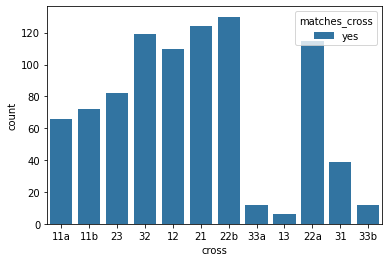

In [81]:
sns.countplot(data = filtered_genotypes, x = 'cross', hue = 'matches_cross')
# visualize the number of matching cross for each plate


In [82]:
read_count_frac_dict = mutant_df[min_read_count].groupby(['cross'])['plate'].count().to_dict()
read_count_frac_dict

{'11a': 184,
 '11b': 185,
 '12': 182,
 '13': 165,
 '21': 191,
 '22a': 159,
 '22b': 190,
 '23': 186,
 '31': 139,
 '32': 187,
 '33a': 191,
 '33b': 135}

In [ ]:
n_passing_filter_dict = filtered_genotypes.groupby(['cross'])['plate'].count().to_dict()
key_order = ['11a', '11b', '12', '21', '13', '31', '22a', '22b', '23', '32', '33a', '33b']

In [87]:
palette = sns.color_palette('gist_gray', 3)
palette

[(0.25098039215686274, 0.25098039215686274, 0.25098039215686274),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.7529411764705882, 0.7529411764705882, 0.7529411764705882)]

(0.0, 115.0)

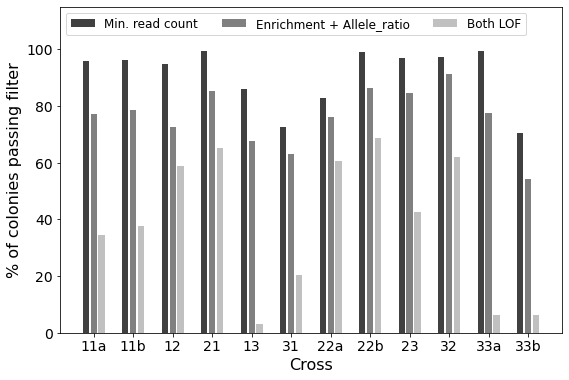

In [89]:
plt.figure(figsize=(9,6))

bar_index = 0 

for x in range(0,12):
    
    cross = key_order[x]
    
    info_list = [read_count_frac_dict[cross], mut_enrich_ratio[cross], no_wt_lof_pair[cross]]
    
    for cat in range(0,3):
        
        plt.bar(((bar_index*5)+cat), info_list[cat]/192*100, color=palette[cat])
        
    bar_index+=1
        
plt.xticks([(x*5)+1 for x in range(0,12)], key_order, fontsize=14)
plt.xlabel('Cross', fontsize=16)
plt.ylabel('% of colonies passing filter', fontsize=16)
plt.yticks(fontsize=14)

plt.legend(['Min. read count', 'Enrichment + Allele_ratio', 'Both LOF'], ncol=3, fontsize=12, loc='upper left')

plt.ylim(0,115)

## Make supp figure on filtering sequences 

1802.5


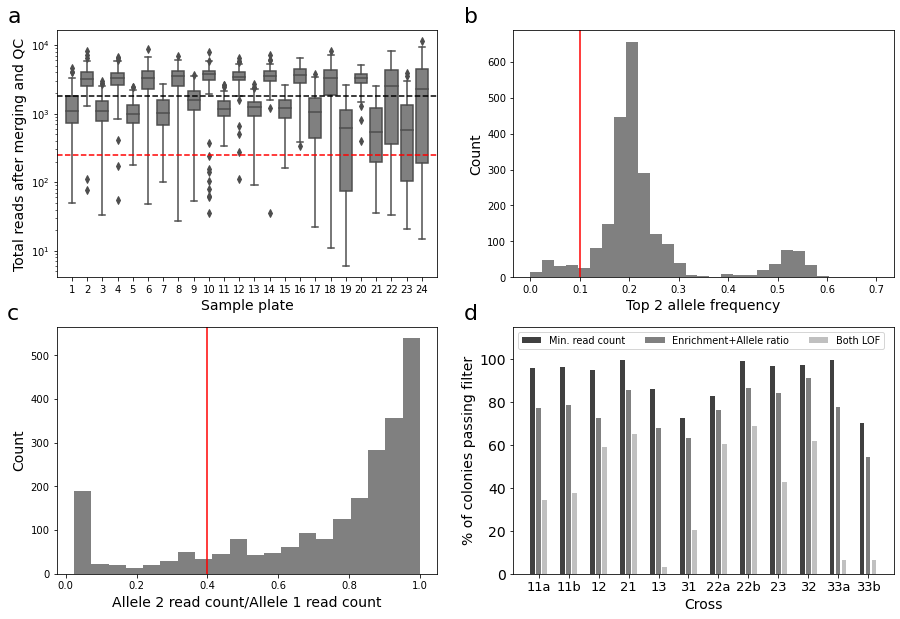

In [90]:
plt.figure(figsize = (15,10))

###################### reads per plate distribution
plt.subplot(221)

ax1 = sns.boxplot(data = mutant_df, x='plate', y='total_read_count', color = 'grey')
plt.yscale('log')

plt.axhline(np.median(mutant_df['total_read_count']), color='k', linestyle='--')

plt.axhline(251, color='r', linestyle='--')


print(np.median(mutant_df['total_read_count']))

plt.xlim(-1,24)
plt.ylabel('Total reads after merging and QC', fontsize=14)
plt.xlabel('Sample plate', fontsize=14)

plt.text(-0.13,1.03, 'a', fontsize=22, transform = ax1.transAxes)

##################### top 2 allele frequency
ax2 = plt.subplot(222)

plt.hist(mutant_df['enrichment'], color='grey', bins=np.linspace(0,0.7,30))
plt.text(-0.13,1.03, 'b', fontsize=22, transform = ax2.transAxes)


plt.ylabel('Count', fontsize=14)
plt.xlabel('Top 2 allele frequency', fontsize=14)

plt.axvline(0.1, color='red')



##################### top 2 allele abundance ratio
ax3 = plt.subplot(223)

plt.hist(mutant_df['top_allele_ratio'], bins=20, color='grey')

plt.ylabel('Count', fontsize=14)
plt.xlabel('Allele 2 read count/Allele 1 read count', fontsize=14)

plt.axvline(0.4, color='red')

plt.text(-0.13,1.03, 'c', fontsize=22, transform = ax3.transAxes)


##################### Attrition at the different filtering steps
ax4 = plt.subplot(224)

bar_index = 0 

for x in range(0,12):
    
    cross = key_order[x]
    
    info_list = [read_count_frac_dict[cross], mut_enrich_ratio[cross], no_wt_lof_pair[cross]]
    
    for cat in range(0,3):
        
        plt.bar(((bar_index*5)+cat), info_list[cat]/192*100, color=palette[cat])
        
    bar_index+=1
        
plt.xticks([(x*5)+1 for x in range(0,12)], key_order, fontsize=13)
plt.xlabel('Cross', fontsize=14)
plt.ylabel('% of colonies passing filter', fontsize=14)
plt.yticks(fontsize=14)

plt.legend(['Min. read count', 'Enrichment+Allele ratio', 'Both LOF'], ncol=3, fontsize=9.75, loc='upper left')

plt.text(-0.13,1.03, 'd', fontsize=22, transform = ax4.transAxes)


plt.ylim(0,115)

plt.savefig('./figures/single_col_filtering.svg', format='svg', dpi=300)

## Count number of occurences of mutation pairs

In [97]:
from collections import Counter


pair_counter = Counter()
# container

for index in filtered_genotypes.index:
    mut_1 = filtered_genotypes.loc[index]['allele_1']      
    mut_2 = filtered_genotypes.loc[index]['allele_2']
    # loop through df and get mutations
    
    mut_pair = tuple(sorted([mut_1, mut_2]))
    # sort mutations so the order is uniform across samples (breaks the allele 1/allele 2 link)
    
    pair_counter[mut_pair]+=1
    
    
    

Text(0, 0.5, 'Count')

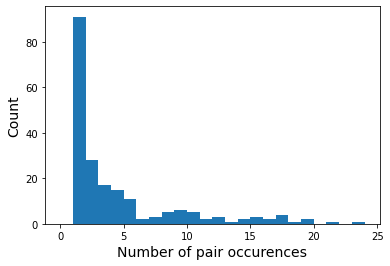

In [100]:
plt.hist(pair_counter.values(), bins=range(0,25))
plt.xlabel('Number of pair occurences', fontsize=14)
plt.ylabel('Count', fontsize=14)
# distribution of number of observations

In [101]:
unique_variant_list = []
# make a list of unique variants pairs involved in complementing pairs

for key in pair_counter.keys():
    if key[0] not in unique_variant_list:
        unique_variant_list.append(key[0])
        
    if key[1] not in unique_variant_list:
        unique_variant_list.append(key[1])
    # loop through variant pairs, if not already in list append to it
    
len(sorted(unique_variant_list))    

103

In [103]:
sorted_unique = sorted(unique_variant_list, key=lambda e: (int(e.split('_')[0][1:-1]), e[1]))
# sorted unique variant pairs by raw abundance


In [104]:
dict_of_dict = {}
# container for all by all heatmap

for unique_var in sorted_unique:
    unique_var_dict = {}
    # loop through unique var pairs
    
    for second_var in sorted_unique:
        unique_var_dict[second_var]=0.1
        # fill the DataFrame with log compatible null values
        
    dict_of_dict[unique_var] = unique_var_dict
    # add to dict
    


In [105]:
for pair in pair_counter.keys():
    
    coords = sorted(pair)
    
    dict_of_dict[coords[0]][coords[1]] += pair_counter[pair]
    dict_of_dict[coords[1]][coords[0]] += pair_counter[pair]
    # add actual abundance values to the DataFrame

<AxesSubplot:>

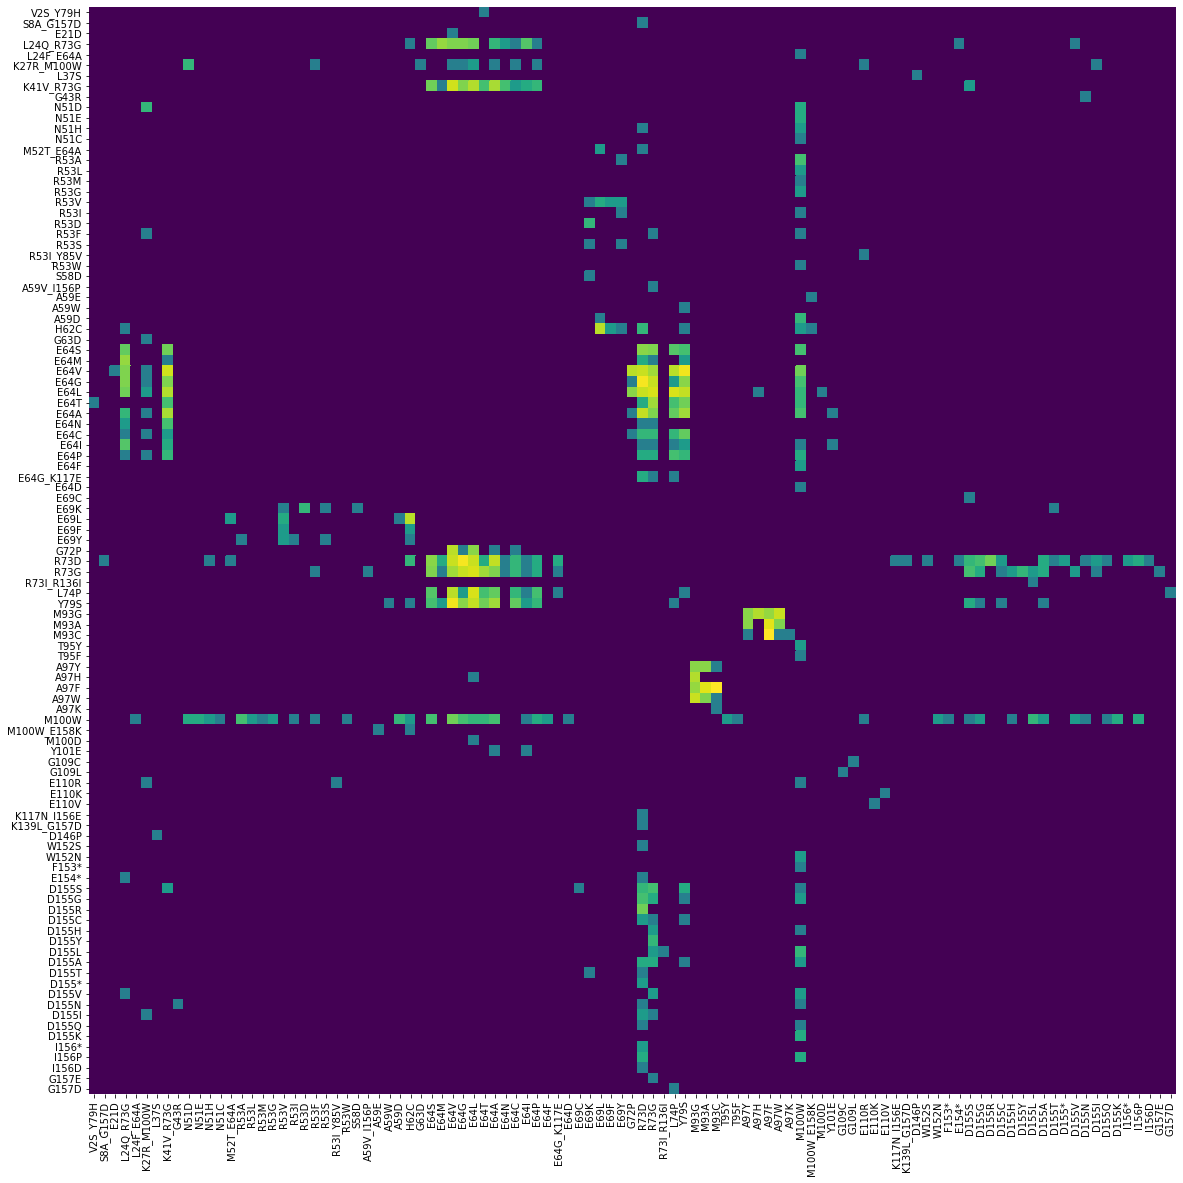

In [108]:
variant_map = pd.DataFrame(dict_of_dict)
# make df

plt.figure(figsize=(20,20))
sns.heatmap(np.log2(variant_map), cmap='viridis', square=True, cbar=False)
# plot df

In [111]:
cross_to_freq_dict = {'11a': (8,11),
                      '11b': (9,11),
                      '12':  (8,17),
                      '21':  (14,11),
                      '13':  (8,23),
                      '31':  (20,11),
                      '22a': (14,17),
                      '22b': (15,17),
                      '23':  (14,23),
                      '32':  (20,17),
                      '33a': (20,23),
                      '33b': (21,23)  }

aa_ranges = {'1':[2,67],
             '2':[49,110],
             '3':[93,158]}
# dicts with info on cross to variant abundance df mapping and cross to mutant pool mapping

{'11a': (8, 11),
 '11b': (9, 11),
 '12': (8, 17),
 '21': (14, 11),
 '13': (8, 23),
 '31': (20, 11),
 '22a': (14, 17),
 '22b': (15, 17),
 '23': (14, 23),
 '32': (20, 17),
 '33a': (20, 23),
 '33b': (21, 23)}

In [112]:
def get_pair_FC_freq(mutant_pair):
    # mutant pair is a tuple of mutations, so only works for single amino acid mutations
    
    mut_1 = mutant_pair[0]
    mut_1_position = mut_1[1:-1]
    mut_1_aa = mut_1[-1]
    
    mut_2 = mutant_pair[1]
    mut_2_position = mut_2[1:-1]
    mut_2_aa = mut_2[-1]
    # get mutant allele info
    
    pair_freq_list = []
    # list container for computed frequqencies across pools
    
    for key in key_order:
        # loop through all possible crosses
        
        mut1_df1_freq = 0
        mut1_df2_freq = 0
        
        mut2_df1_freq = 0
        mut2_df2_freq = 0
        # containers for freq, set to 0
        
        cross_dfs = cross_to_freq_dict[key]
        # mapp cross to abundance df
                       
        freq_df_1 = pd.read_csv(('./parent_variant_abundance/'+str(cross_dfs[0])+'_read_frac.csv'), index_col=0).T
        # variant abundances for the Mata variant pool
        
        if mut_1_position in list(freq_df_1.index):
            for codon in aa_to_codon[mut_1_aa]:
                mut1_df1_freq+=freq_df_1.at[mut_1_position, codon]
        # if mutation 1 in this pool, get freq
                
        if mut_2_position in list(freq_df_1.index):
            for codon in aa_to_codon[mut_2_aa]:
                mut2_df1_freq+=freq_df_1.at[mut_2_position, codon]
        # if mutation 2 in this pool, get freq        
                
        freq_df_2 = pd.read_csv(('./parent_variant_abundance/'+str(cross_dfs[1])+'_read_frac.csv'), index_col=0).T
        # variant abundances for the Mata variant pool
        
        if mut_1_position in list(freq_df_2.index):
            for codon in aa_to_codon[mut_1_aa]:
                mut1_df2_freq+=freq_df_2.at[mut_1_position, codon]
        # if mutation 1 in this pool, get freq
                
        if mut_2_position in list(freq_df_2.index):
            for codon in aa_to_codon[mut_2_aa]:
                mut2_df2_freq+=freq_df_2.at[mut_2_position, codon]
        # if mutation 2 in this pool, get freq      
        
        p_12 = mut1_df1_freq * mut2_df2_freq
        # mut1 freq in pool 1 * mut 2 freq in pool 2
        
        p_21 = mut1_df2_freq * mut2_df1_freq
        # mut1 freq in pool 2 * mut 2 freq in pool 1
        
        p_combi_in_cross = p_12 + p_21
        # sum of probabilities for both cross orientations
        
        pair_freq_list.append(p_combi_in_cross)
        # add expected frequency for this cross to he list
        

    return sum(pair_freq_list), len([x for x in pair_freq_list if x>0])
    # return sum of expected frequencies and number of non-zero frequencies daded up
        
        
            
get_pair_FC_freq(('M100W', 'M100W'))

(1.5125326513996808e-07, 6)

In [113]:
dict_of_dict_pred_freq = {}
# df container for predicted abundance based on frequencies in parental pools

for unique_var in sorted_unique:
    # loop through nique variants
    
    unique_var_dict = {}
    # empty container for col
    
    for second_var in sorted_unique:
        pair = (unique_var, second_var)
        # get pair of variants
        
        if len(unique_var.split('_'))>1 or len(second_var.split('_'))>1:
            unique_var_dict[second_var]=np.NaN
        # if pair involves a double AA mutant, set to NaN
            
        else:
            unique_var_dict[second_var] = get_pair_FC_freq(pair)[0]
        # else compute the expected frequency
        
    dict_of_dict_pred_freq[unique_var] = unique_var_dict
    # add info to dict of dict
    


In [115]:
freq_map = pd.DataFrame.from_dict(dict_of_dict_pred_freq)
freq_map
# make df

,V2S_Y79H,S8A_G157D,E21D,L24Q_R73G,L24F_E64A,K27R_M100W,L37S,K41V_R73G,G43R,N51D,...,D155V,D155N,D155I,D155Q,D155K,I156*,I156P,I156D,G157E,G157D
V2S_Y79H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S8A_G157D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E21D,NaN,NaN,8.010167e-08,NaN,NaN,NaN,0.000002,NaN,2.971746e-07,7.899288e-07,...,0.000001,5.316628e-07,7.850253e-07,4.491182e-07,3.450902e-07,5.870807e-07,0.000002,3.269915e-07,3.946958e-08,8.411219e-08
L24Q_R73G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L24F_E64A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I156*,NaN,NaN,5.870807e-07,NaN,NaN,NaN,0.000016,NaN,2.323382e-06,5.895016e-06,...,0.000039,1.966018e-05,2.519433e-05,1.250509e-05,8.798498e-06,1.479902e-05,0.000041,4.764657e-06,9.422378e-07,1.920542e-06
I156P,NaN,NaN,2.002558e-06,NaN,NaN,NaN,0.000056,NaN,8.237117e-06,1.795186e-05,...,0.000119,6.101305e-05,7.716104e-05,3.771309e-05,2.510991e-05,4.135903e-05,0.000112,1.146154e-05,2.594420e-06,5.149912e-06
I156D,NaN,NaN,3.269915e-07,NaN,NaN,NaN,0.000009,NaN,1.436676e-06,2.297723e-06,...,0.000018,9.700601e-06,1.186098e-05,5.561952e-06,3.121939e-06,4.764657e-06,0.000011,5.040061e-07,2.817724e-07,4.975444e-07
G157E,NaN,NaN,3.946958e-08,NaN,NaN,NaN,0.000001,NaN,1.588003e-07,3.783607e-07,...,0.000003,1.322392e-06,1.682681e-06,8.283753e-07,5.662520e-07,9.422378e-07,0.000003,2.817724e-07,5.953878e-08,1.197472e-07


## Rarefaction curve

In [119]:
filtered_genotypes[filtered_genotypes['cross']=='11b']



,plate,well,file,total_read_count,OD_t0,OD_t3,OD_t7,OD_t20,OD_t25,delta_OD,...,enrichment_top6,top_allele_ratio,cross,seq_1_FC_score,seq_2_FC_score,allele_1,allele_2,allele_1_codon,allele_2_codon,matches_cross
195,4,A2,98_3N_agg.fasta,2967,0.18233,0.23480,0.31570,0.74304,1.05280,0.87047,...,12.586957,0.930000,11b,1.047183,0.344910,L24Q_R73G,E64V,CAA_GGA,GTG,yes
196,3,A3,99_0N_agg.fasta,1444,0.15915,0.19940,0.23688,0.69260,0.92948,0.77033,...,10.771429,0.698198,11b,0.344910,1.111080,L24Q_R73G,E64S,CAA_GGA,TCC,yes
201,4,A5,101_3N_agg.fasta,2465,0.15964,0.23659,0.22400,0.31093,0.31878,0.15914,...,11.725000,0.817829,11b,1.192143,0.344910,L24Q_R73G,E64M,CAA_GGA,ATG,yes
206,3,A8,104_0N_agg.fasta,968,0.16465,0.21174,0.32587,1.26550,1.33770,1.17305,...,8.807692,0.974138,11b,0.344910,1.047183,K41V_R73G,E64V,GTA_GGA,GTT,yes
207,4,A8,104_3N_agg.fasta,3225,0.16147,0.22923,0.26215,0.36213,0.24962,0.08815,...,12.744681,0.919872,11b,1.047183,0.344910,K41V_R73G,E64V,GTA_GGA,GTG,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,3,H3,183_0N_agg.fasta,313,0.20867,0.23787,0.51765,1.36960,1.37450,1.16583,...,7.272727,0.739130,11b,0.344910,1.112866,L24Q_R73G,E64G,CAA_GGA,GGG,yes
365,4,H3,183_3N_agg.fasta,845,0.19669,0.21022,0.22162,0.30045,0.39330,0.19661,...,6.083333,0.403846,11b,1.057263,0.344910,K41V_R73G,E64L,GTA_GGA,TTA,yes
367,4,H4,184_3N_agg.fasta,2869,0.18286,0.22479,0.59699,1.30730,1.30170,1.11884,...,11.250000,0.935484,11b,1.149709,0.344910,K41V_R73G,E64A,GTA_GGA,GCC,yes
369,4,H5,185_3N_agg.fasta,1788,0.25740,0.31652,0.51649,1.13720,1.26810,1.01070,...,8.923077,0.988571,11b,0.928756,0.344910,L24Q_R73G,E64I,CAA_GGA,ATC,yes


## make rarefaction curves

In [ ]:
cross_unique_n_dict = {}
cross_unique_counters = {}

for cross in cross_to_freq_dict.keys():
    
    df_slice = filtered_genotypes[filtered_genotypes['cross']==cross]
    
    indexes = list(df_slice.index)
    
    n_hits = len(indexes)
    
    n_unique = 0
    unique_list = []
    
    unique_counter = Counter()
    
    for colony in range(0, n_hits):
        
        
        allele_1, allele_2 = filtered_genotypes.at[indexes[colony], 'allele_1'], filtered_genotypes.at[indexes[colony], 'allele_2']
        
        genotype = sorted((allele_1, allele_2))
        
        if genotype not in unique_list:
            
            unique_list.append(genotype)
            n_unique+=1
            unique_counter[tuple(genotype)]+=1
            
        else:
            unique_counter[tuple(genotype)]+=1
            
    cross_unique_n_dict[cross] = n_unique
    cross_unique_counters[cross] = unique_counter
    
cross_unique_n_dict, no_wt_lof_pair

In [124]:
def get_rarefaction_df(df, n_iter):

    random.seed(1)
    index_list = list(df.index)


    rarefaction_row_dict = {}

    df_index=0

    for n_iter in range(0,n_iter):

        random.shuffle(index_list)

        n_unique = 0

        unique_list = []

        for colony in range(1, len(index_list)+1):


            allele_1, allele_2 = df.at[index_list[colony-1], 'allele_1'], df.at[index_list[colony-1], 'allele_2']

            genotype = sorted((allele_1, allele_2))

            if genotype not in unique_list:

                unique_list.append(genotype)
                n_unique+=1



            rarefaction_row_dict[df_index] = {'iter': n_iter,
                                           'n_sample': colony,
                                           'n_unique': n_unique}

            df_index+=1


    rarefaction_df = pd.DataFrame.from_dict(rarefaction_row_dict).T
    return rarefaction_df

all_crosses = get_rarefaction_df(filtered_genotypes, 100)

In [126]:
rarefaction_df_list = [all_crosses]

for group in [['11a', '11b'], ['12', '21'], ['13', '31'], ['22a','22b'], ['23', '32'], ['33a','33b']]:
    
    rarefaction_df_group = get_rarefaction_df(filtered_genotypes[filtered_genotypes['cross'].isin(group)], 100)
    
    rarefaction_df_list.append(rarefaction_df_group)

In [127]:
rarefaction_df_list[2]['n_sample'].max()

234

In [128]:
sns.color_palette('husl',6)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225)]

In [129]:
colors = ['k'] + sns.color_palette('husl',6)

colors

['k',
 (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225)]

In [130]:
colors = [(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
         (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
         'k',
         (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
          (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
         (0.23299120924703914, 0.639586552066035, 0.9260706093977744)
         ]

z_order = [4,1,5,2,3,6]

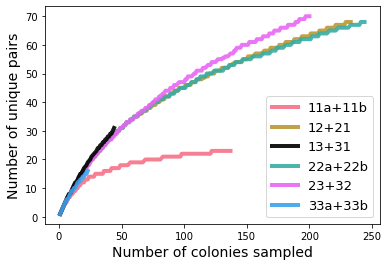

In [131]:
for x in range(1,7):
    
    df = rarefaction_df_list[x]
    
    color=colors[x-1]
    
    for iteration in range(0,100):

        df_slice = df[df['iter'] == iteration]

        #plt.plot(df_slice['n_sample'], df_slice['n_unique'], color=color, alpha = 0.01)


    median_list = []
    
    max_samples = df['n_sample'].max()

    for n_sample in range(1,max_samples):

        df_slice = df[df['n_sample'] == n_sample]

        median_list.append(np.median(df_slice['n_unique']))
        
    plt.plot(range(1, max_samples), median_list, color=color, lw=4, alpha=0.9, zorder=z_order[x-1])

plt.xlabel('Number of colonies sampled', fontsize=14)
plt.ylabel('Number of unique pairs', fontsize=14)

plt.legend(['11a+11b','12+21','13+31', '22a+22b', '23+32', '33a+33b'], loc='lower right', fontsize=13)

Text(0, 0.5, 'Number of unique pairs')

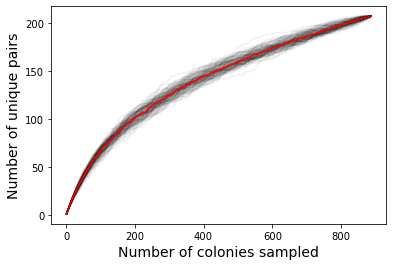

In [132]:
for iteration in range(0,100):
    
    df_slice = all_crosses[all_crosses['iter'] == iteration]
    
    plt.plot(df_slice['n_sample'], df_slice['n_unique'], 'k-', alpha = 0.05)
    

median_list = []

for n_sample in range(1,888):
    
    df_slice = all_crosses[all_crosses['n_sample'] == n_sample]
    
    median_list.append(np.median(df_slice['n_unique']))


plt.plot(range(1,888), median_list, 'r-')

plt.xlabel('Number of colonies sampled', fontsize=14)
plt.ylabel('Number of unique pairs', fontsize=14)

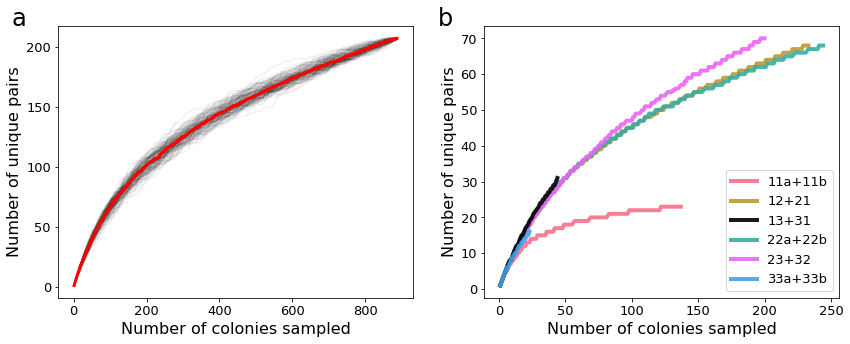

In [133]:
############### make supplementary figure

plt.figure(figsize=(14,5))

ax1 = plt.subplot(121)

for iteration in range(0,100):
    
    df_slice = all_crosses[all_crosses['iter'] == iteration]
    
    plt.plot(df_slice['n_sample'], df_slice['n_unique'], 'k-', alpha = 0.05)
    

median_list = []

for n_sample in range(1,888):
    
    df_slice = all_crosses[all_crosses['n_sample'] == n_sample]
    
    median_list.append(np.median(df_slice['n_unique']))


plt.plot(range(1,888), median_list, 'r-', lw=3)

plt.xlabel('Number of colonies sampled', fontsize=16)
plt.ylabel('Number of unique pairs', fontsize=16)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


ax2 = plt.subplot(122)

for x in range(1,7):
    
    df = rarefaction_df_list[x]
    
    color=colors[x-1]
    
    for iteration in range(0,100):

        df_slice = df[df['iter'] == iteration]

        #plt.plot(df_slice['n_sample'], df_slice['n_unique'], color=color, alpha = 0.01)


    median_list = []
    
    max_samples = df['n_sample'].max()

    for n_sample in range(1,max_samples):

        df_slice = df[df['n_sample'] == n_sample]

        median_list.append(np.median(df_slice['n_unique']))
        
    plt.plot(range(1, max_samples), median_list, color=color, lw=4, alpha=0.9, zorder=z_order[x-1])

plt.xlabel('Number of colonies sampled', fontsize=16)
plt.ylabel('Number of unique pairs', fontsize=16)

plt.legend(['11a+11b','12+21','13+31', '22a+22b', '23+32', '33a+33b'], loc='lower right', fontsize=13)

plt.text(-0.13,1,'a', transform=ax1.transAxes, fontsize=24)
plt.text(-0.13,1,'b', transform=ax2.transAxes, fontsize=24)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig('./figures/rarefaction.svg', format='svg', dpi=300)

## Reorder data by number of independant crosses

In [134]:

independant_crosses_dict = {}
# container for variant pair: n_indep crosses dict


for index in filtered_genotypes.index:
    
    mut_1 = filtered_genotypes.loc[index]['allele_1']
    codon_1 = filtered_genotypes.loc[index]['allele_1_codon']
        
    mut_2 = filtered_genotypes.loc[index]['allele_2']
    codon_2 = filtered_genotypes.loc[index]['allele_2_codon']
    
    cross = filtered_genotypes.loc[index]['cross']
    # get aa, codon, and cross info
    
    key = tuple(sorted([mut_1, mut_2]))
    # sorted variant pair
    
    cross_gen = '_'.join(sorted([codon_1,codon_2]))+'_'+cross
    # add info on cross of origin and shift to codon level
    
    if key not in list(independant_crosses_dict.keys()):
        independant_crosses_dict[key] = [cross_gen]
        # if new, add to dict
        
    elif cross_gen not in independant_crosses_dict[key]:
        independant_crosses_dict[key].append(cross_gen)

    
    
    
#independant_crosses_dict

In [137]:
mut_1_dict = {}
mut_2_dict = {}

n_observed_dict = {}
n_indep_crosses_dict = {}
freq_predicted = {}
# container dicts to make new columns

index = 0

for pair in sorted(((len(v), k) for k, v in independant_crosses_dict.items()), reverse=True):
    
    mut_1_dict[index] = pair[1][0]
    mut_2_dict[index] = pair[1][1]
    
    n_observed_dict[index] = pair_counter[pair[1]]
    n_indep_crosses_dict[index] = pair[0]
    freq_predicted[index] = np.log2(freq_map.at[pair[1][0], pair[1][1]])
    # loop thourhg unique variant pairs and annotate
    
    index+=1

    
indep_crosses_df = pd.DataFrame([pd.Series(mut_1_dict, name='allele_1'), pd.Series(mut_2_dict, name = 'allele_2')]).T
# make new df collapsed at the independant cross level

indep_crosses_df['n_observed'] = pd.Series(n_observed_dict)
indep_crosses_df['n_indep_crosses'] = pd.Series(n_indep_crosses_dict)
indep_crosses_df['freq_predicted'] = pd.Series(freq_predicted)



indep_crosses_df

,allele_1,allele_2,n_observed,n_indep_crosses,freq_predicted
0,E64V,Y79S,24,17,-15.447429
1,E64L,Y79S,16,15,-15.597398
2,E64A,R73D,16,15,-17.132326
3,E69L,H62C,15,13,-16.157550
4,E64L,R73G,19,13,-16.486246
...,...,...,...,...,...
202,A97H,E64L,1,1,-15.629399
203,A59W,Y79S,1,1,-17.490721
204,A59V_I156P,R73G,1,1,NaN
205,A59E,M100W_E158K,1,1,NaN


Text(2.5, -22, 'pval=2.802e-10')

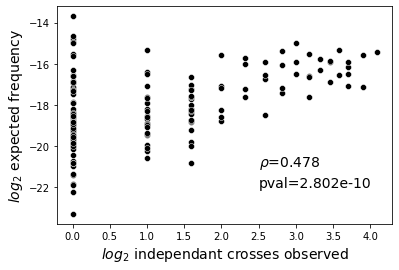

In [142]:
sns.scatterplot(x=np.log2(indep_crosses_df['n_indep_crosses']), y=indep_crosses_df['freq_predicted'], color='k')


plt.xlabel(r'$log_{2}$ independant crosses observed', fontsize=14)
plt.ylabel(r'$log_{2}$ expected frequency', fontsize=14)



vals = stats.spearmanr(indep_crosses_df['n_indep_crosses'], indep_crosses_df['freq_predicted'], nan_policy='omit')
plt.text(2.5,-21, r'$\rho$='+str(np.round(vals[0], 3)), fontsize=14)
plt.text(2.5,-22, 'pval='+str(np.format_float_scientific(vals[1],3)), fontsize=14)

In [147]:
stats.ks_2samp(np.log2(pd.DataFrame(np.tril(freq_map, k=-1)).replace(0, np.nan)).to_numpy().flatten(), indep_crosses_df['freq_predicted'])

KstestResult(statistic=0.4376172268281921, pvalue=6.816284201882836e-36)

## Occurence per aa position

In [148]:
n_occurence_dict = Counter()

for row in indep_crosses_df.index:
    allele_1, allele_2 = indep_crosses_df.at[row, 'allele_1'], indep_crosses_df.at[row, 'allele_2']
    # loop and count
    
    for mut in allele_1.split('_'):
        pos = mut[1:-1]
        # get aa pos
        
        if pos not in ['24', '27', '41']:
            n_occurence_dict[pos]+=1
            # filter out secondary mutations presumed to be neutral
        
    for mut in allele_2.split('_'):
        pos = mut[1:-1]
        # get aa pos
            
        if pos not in ['24', '27', '41']:
            n_occurence_dict[pos]+=1
            # filter out secondary mutations presumed to be neutral
        
most_common_aa = n_occurence_dict.most_common(15)

In [150]:
95+39+8+6, (95+39+8+6)/207

(148, 0.714975845410628)

Text(0.5, 0, 'Residue')

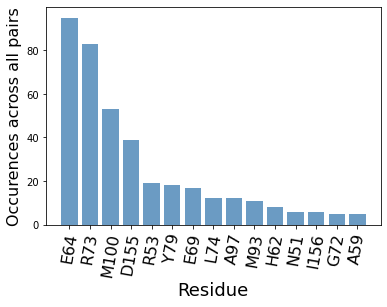

In [152]:
plt.bar([x for x in range(0,15)], [x[1] for x in most_common_aa], color='steelblue', alpha=0.8)
plt.xticks([x for x in range(0,15)], [wt_prot[int(x[0])-1] + x[0] for x in most_common_aa], rotation=80, fontsize=16)

plt.ylabel('Occurences across all pairs', fontsize=16)
plt.xlabel('Residue', fontsize=18)

In [153]:
sum(n_occurence_dict.values()), sum([x[1] for x in most_common_aa]), sum([x[1] for x in most_common_aa])/sum(n_occurence_dict.values())
# top 15 positions cover > 90% of pairs

(428, 389, 0.9088785046728972)

In [376]:
pd.DataFrame(np.tril(freq_map, k=-1)).replace(0, np.nan).isna().sum().sum()

6693

In [377]:
len(np.tril(freq_map, k=-1).flatten())-6693

3916

# heatmap with number of indep crosses and frequency

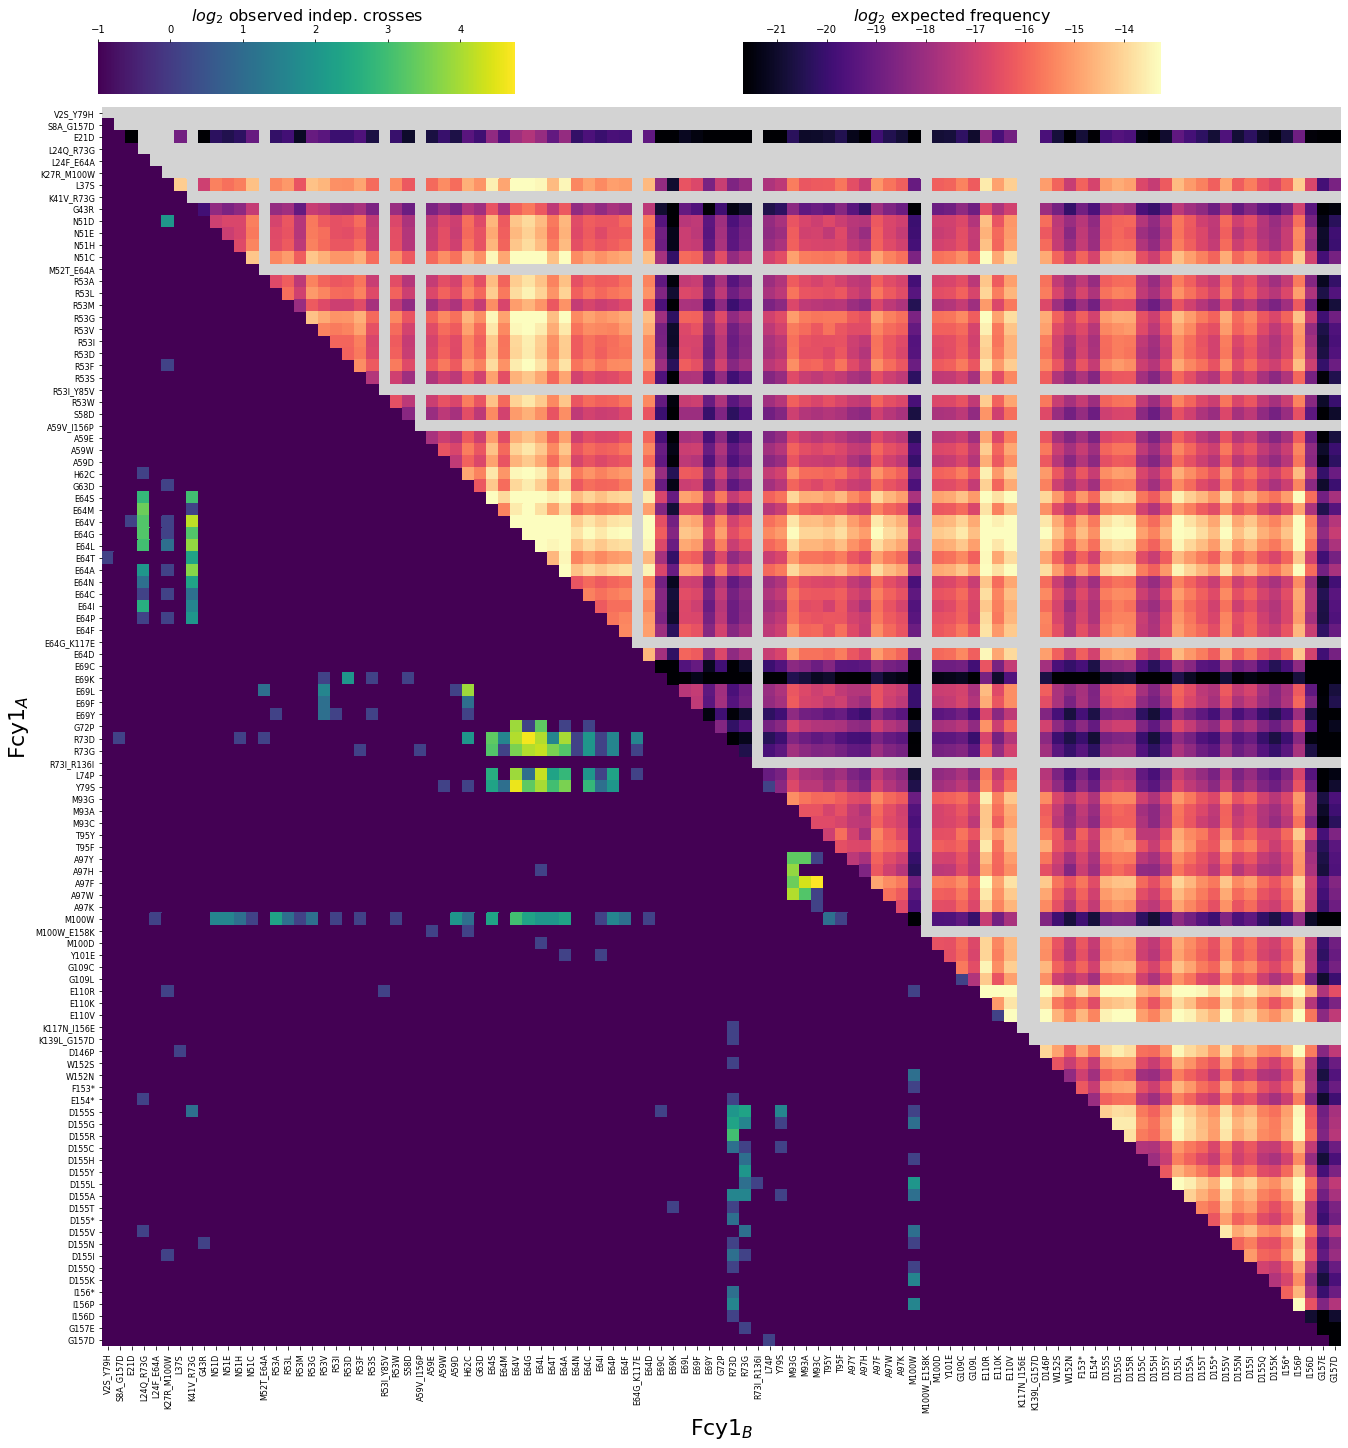

In [446]:
fig = plt.figure(figsize=(24,24))

matrix_0 = np.triu(variant_map)
matrix_1 = np.tril(freq_map, k=-1)
# make masks for the heatmap


f = sns.heatmap(np.log2(variant_map), mask=matrix_0,cmap="viridis", square=True, vmin=-1, xticklabels=1, 
                yticklabels=1, cbar_kws=dict(label=r'$log_{2}$ observed indep. crosses', use_gridspec=False, 
                location="top", aspect=8, anchor=(0.05,0), fraction=0.04, shrink=0.4, pad=-0.04))

f.figure.axes[-1].xaxis.label.set_size(16)
# make heatmap and adjust colorbar label size


g = sns.heatmap(np.log2(freq_map), mask=matrix_1, cmap="magma", cbar_kws=dict(use_gridspec=False, location="top", label=r'$log_{2}$ expected frequency',
                                                                              aspect=8, fraction=0.04, shrink=0.4, pad=0.01, anchor=(0.75,0)), 
                square=True, robust=True, xticklabels=1, yticklabels=1)

g.set_facecolor('lightgrey')
g.figure.axes[-1].xaxis.label.set_size(16)
# make heatmap and adjust colorbar label size



plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel('Fcy1$_{B}$', fontsize = 22)
plt.ylabel('Fcy1$_{A}$', fontsize = 22)

plt.savefig('./figures/ncross_freq.svg', format='svg', dpi=300, bbox_inches='tight')

## Focus on pairs involving E64

In [159]:
only_E64 = [x for x in variant_map.index if 'E64' in x]
only_E64

['L24F_E64A',
 'M52T_E64A',
 'E64S',
 'E64M',
 'E64V',
 'E64G',
 'E64L',
 'E64T',
 'E64A',
 'E64N',
 'E64C',
 'E64I',
 'E64P',
 'E64F',
 'E64G_K117E',
 'E64D']

In [160]:
indep_crosses_df[(indep_crosses_df['allele_1'].str.contains('E64')==True) | (indep_crosses_df['allele_1'].str.contains('E64')==True)]

,allele_1,allele_2,n_observed,n_indep_crosses,freq_predicted
0,E64V,Y79S,24,17,-15.447429
1,E64L,Y79S,16,15,-15.597398
2,E64A,R73D,16,15,-17.132326
4,E64L,R73G,19,13,-16.486246
5,E64L,R73D,17,13,-17.090698
...,...,...,...,...,...
164,E64C,K27R_M100W,1,1,NaN
165,E64C,G72P,1,1,-17.207386
166,E64A,Y101E,1,1,-14.665288
167,E64A,K27R_M100W,1,1,NaN


In [162]:
E64_hits = [x for x in variant_map.columns if variant_map.loc[only_E64][x].max()>0.1]

len(only_E64), len(E64_hits)

(16, 15)

/home/phil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


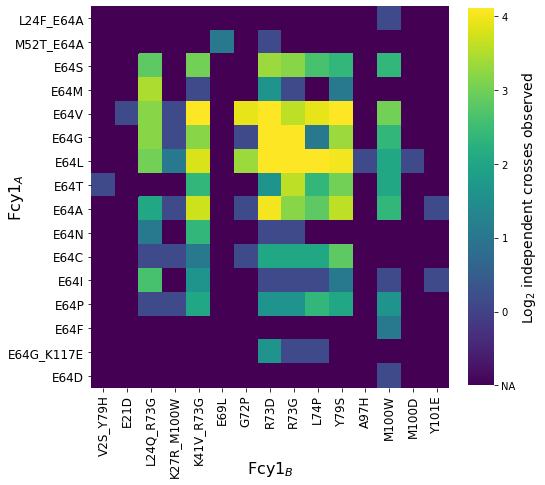

In [443]:
plt.figure(figsize=(8,10))
# make figure panel

g = sns.heatmap(np.log2(variant_map.loc[only_E64][E64_hits]), vmin=-1, vmax=4.1, xticklabels=1, yticklabels=1, cmap='viridis', 
                cbar_kws=dict(label=r'Log$_{2}$ independent crosses observed', shrink=0.54, fraction=0.20, pad=0.04, aspect=14),
                square=True)
g.figure.axes[-1].yaxis.label.set_size(14)
g.figure.axes[-1].yaxis.set_ticklabels(['NA', '0', '1', '2', '3', '4'])

plt.savefig('./figures/figure2/panel_e.pdf', format='pdf', dpi=300)

plt.xlabel('Fcy1$_{B}$', fontsize=16, labelpad=-18)
plt.ylabel('Fcy1$_{A}$', fontsize=16, labelpad=-18)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('./figures/E64_panel.svg', format='svg', dpi=600)

In [176]:
double_mutant_false_pos = ['2', '8', '24', '27', '41', '52', '85', '117', '136', '80', '158', '139']

In [177]:
most_common_aa

[('64', 95),
 ('73', 83),
 ('100', 53),
 ('155', 39),
 ('53', 19),
 ('79', 18),
 ('69', 17),
 ('74', 12),
 ('97', 12),
 ('93', 11),
 ('62', 8),
 ('51', 6),
 ('156', 6),
 ('72', 5),
 ('59', 5)]

In [283]:
def get_put_relevant_res(allele):
    # from an allele, get the most relevant aa position for aggregation
    mut_list = allele.split('_')
    
    if len(mut_list) == 1:
        residue = int(mut_list[0][1:-1])
        return residue
    elif len(mut_list) == 2:
        residue=np.NaN
        for mut in mut_list:
            if mut[1:-1] not in double_mutant_false_pos:
                residue = int(mut[1:-1])
                return residue
    else:
        return np.NaN

In [287]:
indep_crosses_df['residue_1'] = indep_crosses_df.apply(lambda x: get_put_relevant_res(x.allele_1), axis=1)
indep_crosses_df['residue_2'] = indep_crosses_df.apply(lambda x: get_put_relevant_res(x.allele_2), axis=1)

indep_crosses_df

,allele_1,allele_2,n_observed,n_indep_crosses,freq_predicted,distance,allele_1_ddg_struc_het,allele_1_ddg_struc_hm,allele_1_ddg_inter_het,allele_1_ddg_inter_hm,...,allele_2_interface,allele_2_dist_act,allele_2_IC50_score,allele_2_DMSv2_score,sum_ddg_het,sum_ddg_hm,sum_ddg_inter_het,sum_ddg_inter_hm,residue_1,residue_2
0,E64V,Y79S,24,17,-15.447429,21.375284,-0.85807,-1.86945,0.01298,-0.00830,...,0.75,8.740235,0.950865,0.420369,3.50384,6.77892,0.26578,0.24416,64,79
1,E64L,Y79S,16,15,-15.597398,21.375284,-2.17245,-3.58940,0.03412,0.03624,...,0.75,8.740235,0.950865,0.420369,2.18946,5.05897,0.28692,0.28870,64,79
2,E64A,R73D,16,15,-17.132326,17.563004,0.07175,1.13292,0.03700,0.05236,...,1.00,12.085709,0.954408,0.547461,3.12026,7.20229,2.93176,5.83774,64,73
3,E69L,H62C,15,13,-16.157550,11.377219,0.34434,1.41897,1.31188,3.24224,...,0.75,0.000000,0.995737,1.125737,1.92259,4.27368,1.80420,4.00768,69,62
4,E64L,R73G,19,13,-16.486246,17.563004,-2.17245,-3.58940,0.03412,0.03624,...,1.00,12.085709,0.902137,0.344910,-0.02706,0.88322,2.10744,4.28204,64,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,A97H,E64L,1,1,-15.629399,12.480150,7.56764,12.51737,4.33446,6.12788,...,0.75,0.000000,1.009000,1.057263,5.39519,8.92797,4.36858,6.16412,97,64
203,A59W,Y79S,1,1,-17.490721,11.614344,32.74996,63.68554,24.87165,51.68332,...,0.75,8.740235,0.950865,0.420369,37.11187,72.33391,25.12445,51.93578,59,79
204,A59V_I156P,R73G,1,1,NaN,NaN,6.03832,12.31604,-0.65552,-1.02480,...,1.00,12.085709,0.902137,0.344910,8.18371,16.78866,1.41780,3.22100,59,73
205,A59E,M100W_E158K,1,1,NaN,NaN,5.40601,12.75700,3.13388,9.12192,...,1.00,5.711372,0.550655,0.334764,12.30686,28.19398,9.37144,23.20086,59,100


In [424]:
all_unique_res = set(list(indep_crosses_df['residue_1'].unique())+list(indep_crosses_df['residue_2'].unique()))
# list of all unique aa positions

res_by_res_count_matrix = {}
# empty container

for res1 in all_unique_res:
    res_by_res_count_matrix[res1]={}
    for res2 in all_unique_res:
        res_by_res_count_matrix[res1][res2]=0
# set up the dict of dicts
        

for index in list(indep_crosses_df.index):
    res1, res2 = indep_crosses_df.at[index, 'residue_1'],  indep_crosses_df.at[index, 'residue_2']
    
    res_by_res_count_matrix[res1][res2]+= 1
    res_by_res_count_matrix[res2][res1]+= 1
# populate it with aa-aa pairs observed
    
res_by_res_count_df = pd.DataFrame.from_dict(res_by_res_count_matrix)
res_by_res_count_df.sort_index(inplace=True)
res_by_res_count_df.sort_index(inplace=True, axis=1)
# make df and sort it
res_by_res_count_df

,21,37,43,51,53,58,59,62,63,64,...,101,109,110,146,152,153,154,155,156,157
21,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
51,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


In [434]:
keep_cols = list(res_by_res_count_df.columns[((res_by_res_count_df != 0).sum() > 2)|(res_by_res_count_df.max() > 2)])
# filter for more than 2 total pairs per residue
res_by_res_count_df.loc[keep_cols][keep_cols]

,51,53,59,62,64,69,72,73,74,79,93,97,100,110,155,156,157
51,0,0,0,0,0,0,0,1,0,0,0,0,5,0,0,0,0
53,0,0,0,0,0,9,0,1,0,0,0,0,8,1,0,0,0
59,0,0,0,0,0,1,0,1,0,1,0,0,2,0,0,0,0
62,0,0,0,0,0,3,0,2,0,1,0,0,2,0,0,0,0
64,0,0,0,0,0,1,5,46,10,11,0,1,18,0,0,0,0
69,0,9,1,3,1,0,0,0,0,0,0,0,0,0,2,0,0
72,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
73,1,1,1,2,46,0,0,0,0,0,0,0,0,0,22,4,3
74,0,0,0,0,10,0,0,0,0,1,0,0,0,0,0,0,1
79,0,0,1,1,11,0,0,0,1,0,0,0,0,0,4,0,0


In [439]:
res_by_res_count_df.loc[keep_cols][keep_cols].sum().sum()/2

192.0

In [440]:
192/207

0.927536231884058

Text(51.0, 0.5, 'Residue A')

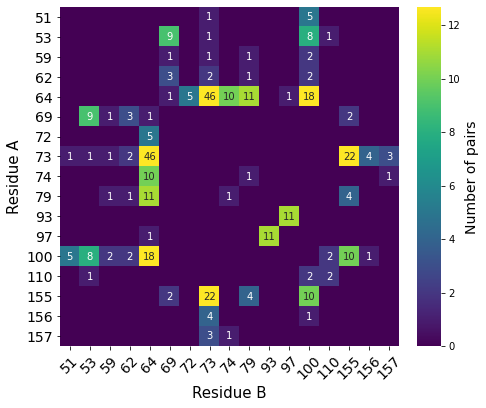

In [441]:
f = plt.figure(figsize=(8,8))

ax = sns.heatmap(res_by_res_count_df.loc[keep_cols][keep_cols], cmap='viridis', robust=True, square=True, annot=True, cbar_kws=dict(label=r'Number of pairs', shrink=0.78, fraction=0.20, pad=0.04, aspect=14))
ax.figure.axes[-1].yaxis.label.set_size(14)
# make the heatmap


for t in ax.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text())
        # annotate if value > 0
    else:
        t.set_text("")
        # if not it sets an empty text

plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('Residue B', fontsize=15)
plt.ylabel('Residue A', fontsize=15)
plt.savefig('./figures/residue_by_residue.svg', format='svg', dpi=600)

## Commands to generate ChimeraX residue interaction network (Figure 2e)

In [196]:
indep_crosses_df.to_csv('../indep_crosses.csv', sep=',')
# save file for supp material

In [197]:
dict_of_dict_independant = {}

for unique_var in sorted_unique:
    
    unique_var_dict = {}
    
    for second_var in sorted_unique:
        
        unique_var_dict[second_var]=0.5
        
    dict_of_dict_independant[unique_var] = unique_var_dict

In [198]:
for pair in independant_crosses_dict.keys():
    
    dict_of_dict_independant[pair[0]][pair[1]] += len(independant_crosses_dict[pair])
    dict_of_dict_independant[pair[1]][pair[0]] += len(independant_crosses_dict[pair])
dict_of_dict_independant['E64V']

{'V2S_Y79H': 0.5,
 'S8A_G157D': 0.5,
 'E21D': 1.5,
 'L24Q_R73G': 4.5,
 'L24F_E64A': 0.5,
 'K27R_M100W': 1.5,
 'L37S': 0.5,
 'K41V_R73G': 6.5,
 'G43R': 0.5,
 'N51D': 0.5,
 'N51E': 0.5,
 'N51H': 0.5,
 'N51C': 0.5,
 'M52T_E64A': 0.5,
 'R53A': 0.5,
 'R53L': 0.5,
 'R53M': 0.5,
 'R53G': 0.5,
 'R53V': 0.5,
 'R53I': 0.5,
 'R53D': 0.5,
 'R53F': 0.5,
 'R53S': 0.5,
 'R53I_Y85V': 0.5,
 'R53W': 0.5,
 'S58D': 0.5,
 'A59V_I156P': 0.5,
 'A59E': 0.5,
 'A59W': 0.5,
 'A59D': 0.5,
 'H62C': 0.5,
 'G63D': 0.5,
 'E64S': 0.5,
 'E64M': 0.5,
 'E64V': 0.5,
 'E64G': 0.5,
 'E64L': 0.5,
 'E64T': 0.5,
 'E64A': 0.5,
 'E64N': 0.5,
 'E64C': 0.5,
 'E64I': 0.5,
 'E64P': 0.5,
 'E64F': 0.5,
 'E64G_K117E': 0.5,
 'E64D': 0.5,
 'E69C': 0.5,
 'E69K': 0.5,
 'E69L': 0.5,
 'E69F': 0.5,
 'E69Y': 0.5,
 'G72P': 12.5,
 'R73D': 11.5,
 'R73G': 10.5,
 'R73I_R136I': 0.5,
 'L74P': 10.5,
 'Y79S': 17.5,
 'M93G': 0.5,
 'M93A': 0.5,
 'M93C': 0.5,
 'T95Y': 0.5,
 'T95F': 0.5,
 'A97Y': 0.5,
 'A97H': 0.5,
 'A97F': 0.5,
 'A97W': 0.5,
 'A97K': 0.5,

In [201]:
indep_crosses_dist = [len(independant_crosses_dict[x]) for x in independant_crosses_dict.keys()]
np.median(indep_crosses_dist), max(indep_crosses_dist), sum(indep_crosses_dist), len(independant_crosses_dict.keys())

(2.0, 17, 613, 207)

Text(0, 0.5, 'Count')

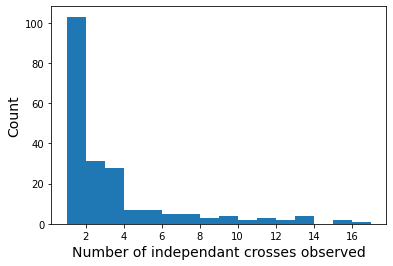

In [202]:
plt.hist(indep_crosses_dist, bins=range(1,18))
plt.xlabel('Number of independant crosses observed', fontsize=14)
plt.ylabel('Count', fontsize=14)

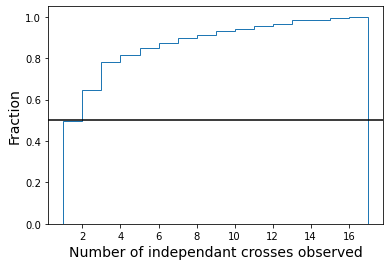

In [203]:
plt.hist(indep_crosses_dist, bins=range(1,18), histtype='step', cumulative=True, density=True)
plt.xlabel('Number of independant crosses observed', fontsize=14)
plt.ylabel('Fraction', fontsize=14)
plt.axhline(0.5, color='k')

In [204]:
len([x for x in indep_crosses_dist if x>=2])/len([x for x in indep_crosses_dist])

0.5024154589371981

In [205]:


single_mut_dict = {}

for key in independant_crosses_dict:
    
    mut_1, mut_2 = key[0], key[1]
    
    if mut_1 not in single_mut_dict.keys():
        single_mut_dict[mut_1] = len(independant_crosses_dict[key])
    else:
        single_mut_dict[mut_1] += len(independant_crosses_dict[key])
        
    if mut_2 not in single_mut_dict.keys():
        single_mut_dict[mut_2] = len(independant_crosses_dict[key])
    else:
        single_mut_dict[mut_2] += len(independant_crosses_dict[key])
        
sum(single_mut_dict.values())/2

613.0

In [206]:
different_pairs_dict = {}

for key in independant_crosses_dict:
    
    mut_1, mut_2 = key[0], key[1]
    
    if mut_1 not in different_pairs_dict.keys():
        different_pairs_dict[mut_1] = 1
    else:
        different_pairs_dict[mut_1] += 1
        
    if mut_2 not in different_pairs_dict.keys():
        different_pairs_dict[mut_2] = 1
    else:
        different_pairs_dict[mut_2] += 1

sum(different_pairs_dict.values())

414

In [207]:
different_pairs_dict['E64A']

10

In [208]:
mut_dict = {}
n_occurence_dict = {}
n_diff_pairs = {}

index=0

for x in single_mut_dict.keys():
    
    mut_dict[index] = x
    n_occurence_dict[index] = single_mut_dict[x]
    n_diff_pairs[index] = different_pairs_dict[x]
    
    index+=1
    
single_mut_df = pd.concat([pd.Series(mut_dict, name='mutant'), pd.Series(n_occurence_dict, name='in_n_crosses'), pd.Series(n_diff_pairs, name='in_n_pairs')], axis=1)
single_mut_df

,mutant,in_n_crosses,in_n_pairs
0,E64S,38,7
1,K41V_R73G,37,12
2,E64M,9,5
3,L24Q_R73G,28,13
4,E64V,79,10
...,...,...,...
98,N51C,1,1
99,W152N,1,1
100,F153*,1,1
101,G109C,1,1


In [209]:
single_mut_df.sort_values('in_n_pairs', ascending=False).head(40)

,mutant,in_n_crosses,in_n_pairs
42,M100W,73,39
17,R73D,114,33
25,R73G,96,24
34,Y79S,76,17
3,L24Q_R73G,28,13
60,L74P,48,12
1,K41V_R73G,37,12
51,K27R_M100W,13,11
6,E64L,76,11
4,E64V,79,10


Text(0, 0.5, 'Density')

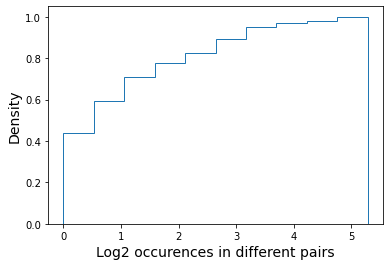

In [210]:
plt.hist(np.log2(single_mut_df['in_n_pairs']), histtype='step', cumulative=True, density=True)

plt.xlabel('Log2 occurences in different pairs', fontsize=14)
plt.ylabel('Density', fontsize=14)

## Get distance between mutant sites and to active site

In [211]:
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import Selection


In [212]:
parser = MMCIFParser()

In [213]:
structure = parser.get_structure('1p6o', '../chimeraX/1p6o.cif')

/home/phil/anaconda3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2507.
  PDBConstructionWarning,
/home/phil/anaconda3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2520.
  PDBConstructionWarning,
/home/phil/anaconda3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2539.
  PDBConstructionWarning,
/home/phil/anaconda3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2741.
  PDBConstructionWarning,


In [214]:
model = structure[0]
model['A']

<Chain id=A>

## Get distances within monomer and to other subunit

In [215]:
distance_dist_hm = []

distance_dist_het = []


for residue1 in model['A']:
    for residue2 in model['A']:
        if residue1 != residue2:
      
            # compute distance between CA atoms
            try:
                distance = residue1['CA'] - residue2['CA']
                distance_dist_hm.append(distance)
            except KeyError:
                ## no CA atom, e.g. for H_NAG
                continue
                
                
for residue1 in model['A']:
    for residue2 in model['B']:
        # compute distance between CA atoms
            try:
                distance = residue1['CA'] - residue2['CA']
                distance_dist_het.append(distance)
            except KeyError:
                ## no CA atom, e.g. for H_NAG
                continue

(array([ 162.,  743., 2034., 3819., 5335., 5567., 4247., 2540.,  871.,
         110.]),
 array([ 3.8386796,  8.982184 , 14.125689 , 19.269194 , 24.412697 ,
        29.556202 , 34.699707 , 39.843212 , 44.986713 , 50.13022  ,
        55.273724 ], dtype=float32),
 <BarContainer object of 10 artists>)

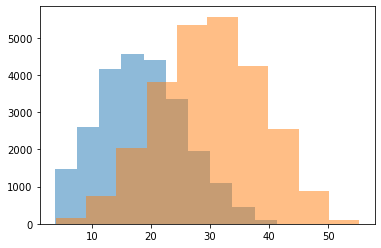

In [216]:
plt.hist(distance_dist_hm, alpha=0.5)

plt.hist(distance_dist_het, alpha =0.5)



In [217]:
max(distance_dist_het)

55.273724

In [220]:
def get_fragment(fcy1_pos):
    # from a fcy1 position, get the DMS pools where it was mutagenized.
    # helper function to build a null distribution from pairs of LOF mutations
    if fcy1_pos < 49:
        return [1]
    elif fcy1_pos >=49 and fcy1_pos <68:
        return [1,2]
    elif fcy1_pos>=68 and fcy1_pos < 94:
        return [2]
    elif fcy1_pos>=94 and fcy1_pos <111:
        return [2,3]
    elif fcy1_pos>=111:
        return[3]
    
get_fragment(64)

[1, 2]

In [221]:
def get_dist_heteromer(mut_1, mut_2, model):
    # get distance between two residues in different subunits
    
    coord_A_mut_1 = int(mut_1[1:-1])
    coord_B_mut_1 = int(mut_1[1:-1])+200
    
    coord_A_mut_2 = int(mut_2[1:-1])
    coord_B_mut_2 = int(mut_2[1:-1])+200
    
    distA_B = model['A'][coord_A_mut_1]['CA'] - model['B'][coord_B_mut_2]['CA']
    distB_A = model['B'][coord_B_mut_1]['CA'] - model['A'][coord_A_mut_2]['CA']
    
    return distA_B, distB_A
    
get_dist_heteromer('E64V', 'M100W', model=model)

(13.706925, 13.834744)

## Compare AB to BA disatnce to look for major inconsistencies

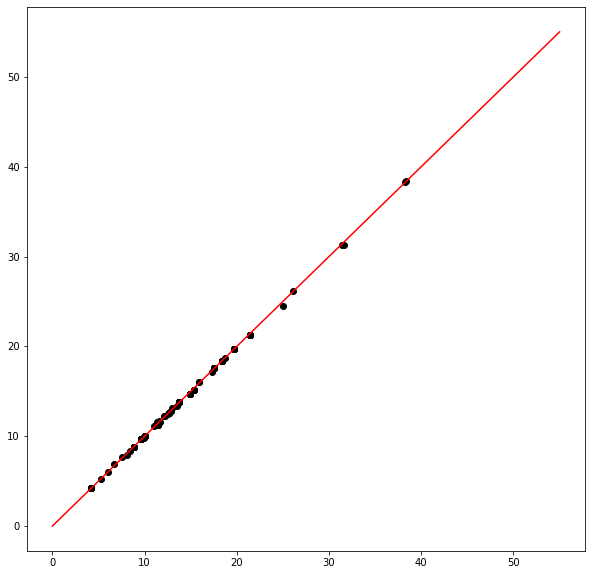

In [222]:
plt.figure(figsize=(10,10))
for pair in list(indep_crosses_df.index):
    
    mut_1 = indep_crosses_df.at[pair, 'allele_1']
    mut_2 = indep_crosses_df.at[pair, 'allele_2']
    
    if len(mut_1.split('_'))==1 and len(mut_2.split('_')) == 1:
        
        dists = get_dist_heteromer(mut_1, mut_2, model=model)
    
        plt.plot(dists[0], dists[1], 'ko')
plt.plot([0,55], [0,55], 'r-')
# take the average

## Get distances for the complementing pairs

In [223]:
indep_crosses_df['distance'] = np.NaN
for pair in list(indep_crosses_df.index):
    
    mut_1 = indep_crosses_df.at[pair, 'allele_1']
    mut_2 = indep_crosses_df.at[pair, 'allele_2']
    
    if len(mut_1.split('_'))==1 and len(mut_2.split('_')) == 1:
        
        dists = get_dist_heteromer(mut_1, mut_2, model=model)
        mean_dist = np.mean(dists)
        indep_crosses_df.at[pair, 'distance'] = mean_dist
        


In [224]:
indep_crosses_df

,allele_1,allele_2,n_observed,n_indep_crosses,freq_predicted,distance
0,E64V,Y79S,24,17,-15.447429,21.375284
1,E64L,Y79S,16,15,-15.597398,21.375284
2,E64A,R73D,16,15,-17.132326,17.563004
3,E69L,H62C,15,13,-16.157550,11.377219
4,E64L,R73G,19,13,-16.486246,17.563004
...,...,...,...,...,...,...
202,A97H,E64L,1,1,-15.629399,12.480150
203,A59W,Y79S,1,1,-17.490721,11.614344
204,A59V_I156P,R73G,1,1,NaN,NaN
205,A59E,M100W_E158K,1,1,NaN,NaN


<AxesSubplot:xlabel='distance', ylabel='Density'>

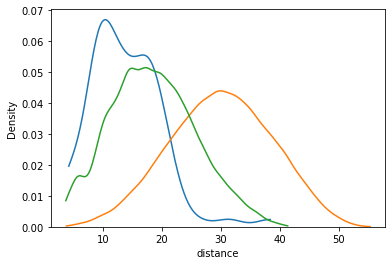

In [225]:
sns.kdeplot(indep_crosses_df['distance'], cut=0)
sns.kdeplot(distance_dist_het, cut=0)
sns.kdeplot(distance_dist_hm, cut=0)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa2149b0fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa2149bc890>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa2149b0c10>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa2149c7150>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa2149c7550>,
 'means': []}

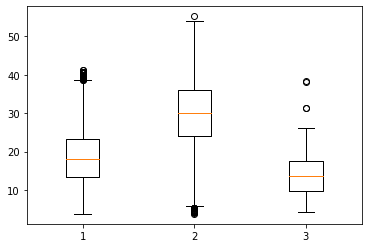

In [226]:
plt.boxplot([distance_dist_hm, distance_dist_het, indep_crosses_df['distance'].dropna()], )

## Import DMS data to get full pool of LOF variants

In [227]:
DMSv2_LOF = DMSv2_score[DMSv2_score['overall_median'] >0.31]
DMSv2_LOF

,codon,wt,measured,mat_a_1_1,mat_a_1_2,mat_a_1_3,mat_a_2_1,mat_a_2_2,mat_a_2_3,mat_a_3_1,...,mat_alpha_3_3_norm,mat_a_1_norm_median,mat_a_2_norm_median,mat_a_3_norm_median,mat_alpha_1_norm_median,mat_alpha_2_norm_median,mat_alpha_3_norm_median,FC_score,overall_median,crossed_pool_median
79,5,G,H,-1.259679,-1.620508,-1.813265,NaN,NaN,NaN,NaN,...,NaN,0.454599,NaN,NaN,0.561214,NaN,NaN,-0.268511,0.507906,0.553823
84,6,M,*,1.787567,1.868883,1.799319,NaN,NaN,NaN,NaN,...,NaN,1.089168,NaN,NaN,1.046352,NaN,NaN,0.958475,1.067760,1.089168
98,6,M,N,0.517240,-0.191639,0.215406,NaN,NaN,NaN,NaN,...,NaN,0.802803,NaN,NaN,0.006751,NaN,NaN,0.124447,0.404777,0.711873
105,7,A,*,0.942737,0.494944,0.329411,NaN,NaN,NaN,NaN,...,NaN,0.845510,NaN,NaN,0.172325,NaN,NaN,0.984078,0.508917,0.845510
126,8,S,*,0.683754,0.943320,0.696867,NaN,NaN,NaN,NaN,...,NaN,0.895248,NaN,NaN,0.965565,NaN,NaN,0.983655,0.930407,0.932782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,157,G,*,NaN,NaN,NaN,NaN,NaN,NaN,0.902045,...,0.738669,NaN,NaN,0.973393,NaN,NaN,0.759166,0.989759,0.866280,0.846745
3268,157,G,T,NaN,NaN,NaN,NaN,NaN,NaN,0.824042,...,0.066417,NaN,NaN,0.869979,NaN,NaN,0.073529,0.525564,0.471754,0.833177
3271,157,G,H,NaN,NaN,NaN,NaN,NaN,NaN,-1.475518,...,0.519081,NaN,NaN,0.357907,NaN,NaN,0.533391,-0.170720,0.445649,0.433187
3274,157,G,D,NaN,NaN,NaN,NaN,NaN,NaN,0.511855,...,0.394172,NaN,NaN,0.778874,NaN,NaN,0.507038,0.789267,0.642956,0.778874


In [228]:
frag_tuple_list = []

for pair in list(indep_crosses_df.index):
    
    mut_1 = indep_crosses_df.at[pair, 'allele_1']
    mut_2 = indep_crosses_df.at[pair, 'allele_2']
    
    if len(mut_1.split('_'))==1 and len(mut_2.split('_')) == 1:
        
        frag_tuple_list.append((get_fragment(int(mut_1[1:-1])), get_fragment(int(mut_2[1:-1]))))
        
#frag_tuple_list

In [229]:
LOF_pool_1 = list(DMSv2_LOF[DMSv2_LOF['codon']<68].index)
LOF_pool_2 = list(DMSv2_LOF[(DMSv2_LOF['codon']>48)&(DMSv2_LOF['codon']<111)].index)
LOF_pool_3 = list(DMSv2_LOF[DMSv2_LOF['codon']>92].index)

pool_list = [LOF_pool_1,LOF_pool_2,LOF_pool_3]

In [230]:
len(frag_tuple_list)

156

In [231]:
def draw_mutant_pair(frag_tuple):
    # from a tuple of FCY1 DMS library pools, draw two LOF mutations randomly.
    # will return their indices in the DMS dataFra,e
    pool_A = random.choice(frag_tuple[0])
    pool_B = random.choice(frag_tuple[1])
    
    
    
    random_pair = [random.choice(pool_list[pool_A-1]),random.choice(pool_list[pool_B-1])]
    
    return random_pair
    
draw_mutant_pair(([1],[2]))    

[1030, 2038]

## Generate random distributions and compare with complementing mutants

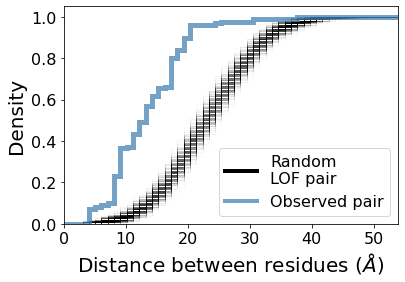

In [234]:
import math as math


for x in range(1,1000):
    
    random.seed(x)
    
    iter_dist = []
    
    for pair in frag_tuple_list:
        
        randomized_pair = draw_mutant_pair(pair)
        
        mut1_pos = math.floor((randomized_pair[0]/21)+2)
        mut2_pos = math.floor((randomized_pair[1]/21)+2)
        
        dist = np.mean(get_dist_heteromer('X'+str(mut1_pos)+'X', 'X'+str(mut2_pos)+'X', model=model))
        
        #print(dist)
        
        iter_dist.append(dist)
        
    plt.hist(iter_dist, histtype='step', cumulative=True,density=True, bins=np.linspace(0,55,55), alpha=0.01, color='k')
                
        
        
plt.hist(indep_crosses_df['distance'].dropna(), histtype='step', cumulative=True, density=True, bins=np.linspace(0,55,55), color='steelblue', linewidth=5, alpha=0.75)

plt.ylabel('Density', fontsize=20, labelpad=5)
plt.xlabel(r'Distance between residues ($\AA$)', fontsize=20)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='steelblue', lw=4, alpha=0.75)]

plt.legend(custom_lines, ['Random\nLOF pair', 'Observed pair'], loc='lower right', fontsize=16)
plt.xlim(0,54)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.savefig('./figures/figure2/panel_h_bigger_font.tiff', format='tiff', dpi=1200, bbox_inches='tight')

## Add interface and distance to active site annotations

In [237]:
S_table_6_df = pd.read_csv('S_table_6_despres_et_al_2022.csv', index_col=0)
# import s_table 6 from despres et al 2022

codon                 int64
wt                   object
measured             object
CY_1                float64
CY_1_R1             float64
CY_1_MAD_1          float64
CY_1_R2             float64
CY_1_MAD_2          float64
FC_1                float64
FC_1_R1             float64
FC_1_MAD_1          float64
FC_1_R2             float64
FC_1_MAD_2          float64
CY_2                float64
CY_2_R1             float64
CY_2_MAD_1          float64
CY_2_R2             float64
CY_2_MAD_2          float64
FC_2                float64
FC_2_R1             float64
FC_2_MAD_1          float64
FC_2_R2             float64
FC_2_MAD_2          float64
FC_CY_2             float64
FC_CY_2_R1          float64
FC_CY_2_MAD_1       float64
FC_CY_2_R2          float64
FC_CY_2_MAD_2       float64
CY_3                float64
CY_3_R1             float64
CY_3_MAD_1          float64
CY_3_R2             float64
CY_3_MAD_2          float64
FC_3                float64
FC_3_R1             float64
FC_3_MAD_1          

## Get interface and distance to active site info

In [242]:
indep_crosses_df['allele_1_interface'] = np.NaN
indep_crosses_df['allele_1_dist_act'] = np.NaN

indep_crosses_df['allele_2_interface'] = np.NaN
indep_crosses_df['allele_2_dist_act'] = np.NaN
# empty new columns


for pair in list(indep_crosses_df.index):
    
    allele_1 = indep_crosses_df.at[pair, 'allele_1']
    allele_2 = indep_crosses_df.at[pair, 'allele_2']
    # get mutant alleles
    
    allele_1_interface = []
    allele_1_dist_act_site = []
        
    for mut in allele_1.split('_'):
        
        wt_aa = mut[0]
        pos = int(mut[1:-1])
        mut_aa = mut[-1]
            
        if S_table_6_df[(S_table_6_df['codon'] == pos)&(S_table_6_df['measured']==mut_aa)].size>0:
            
            allele_1_interface.append(np.float64(S_table_6_df[(S_table_6_df['codon'] == pos)&(S_table_6_df['measured']==mut_aa)]['interface']))
            allele_1_dist_act_site.append(np.float64(S_table_6_df[(S_table_6_df['codon'] == pos)&(S_table_6_df['measured']==mut_aa)]['dist_act_site']))
                        
   
    indep_crosses_df.at[pair, 'allele_1_interface'] = max(allele_1_interface)
    indep_crosses_df.at[pair, 'allele_1_dist_act'] = min(allele_1_dist_act_site)
    # get the info for allele one, take highest interface value and lowest distance if multiple mutations
   
    allele_2_interface = []
    allele_2_dist_act_site = []
    
    for mut in allele_2.split('_'):
        
        wt_aa = mut[0]
        pos = int(mut[1:-1])
        mut_aa = mut[-1]
            
        if S_table_6_df[(S_table_6_df['codon'] == pos)&(S_table_6_df['measured']==mut_aa)].size>0:
            
            allele_2_interface.append(np.float64(S_table_6_df[(S_table_6_df['codon'] == pos)&(S_table_6_df['measured']==mut_aa)]['interface']))
            allele_2_dist_act_site.append(np.float64(S_table_6_df[(S_table_6_df['codon'] == pos)&(S_table_6_df['measured']==mut_aa)]['dist_act_site']))
            

    indep_crosses_df.at[pair, 'allele_2_interface'] = max(allele_2_interface)
    indep_crosses_df.at[pair, 'allele_2_dist_act'] = min(allele_2_dist_act_site)
    # get the info for allele one, take highest interface value and lowest distance if multiple mutations

    
indep_crosses_df        

,allele_1,allele_2,n_observed,n_indep_crosses,freq_predicted,distance,allele_1_ddg_struc_het,allele_1_ddg_struc_hm,allele_1_ddg_inter_het,allele_1_ddg_inter_hm,...,allele_1_IC50_score,allele_1_DMSv2_score,allele_2_ddg_struc_het,allele_2_ddg_struc_hm,allele_2_ddg_inter_het,allele_2_ddg_inter_hm,allele_2_interface,allele_2_dist_act,allele_2_IC50_score,allele_2_DMSv2_score
0,E64V,Y79S,24,17,-15.447429,21.375284,-0.85807,-1.86945,0.01298,-0.00830,...,1.007457,1.047183,4.36191,8.64837,0.25280,0.25246,0.75,8.740235,0.950865,0.420369
1,E64L,Y79S,16,15,-15.597398,21.375284,-2.17245,-3.58940,0.03412,0.03624,...,1.009000,1.057263,4.36191,8.64837,0.25280,0.25246,0.75,8.740235,0.950865,0.420369
2,E64A,R73D,16,15,-17.132326,17.563004,0.07175,1.13292,0.03700,0.05236,...,1.020875,1.149709,3.04851,6.06937,2.89476,5.78538,1.00,12.085709,0.954408,0.547461
3,E69L,H62C,15,13,-16.157550,11.377219,0.34434,1.41897,1.31188,3.24224,...,0.946809,0.598206,1.57825,2.85471,0.49232,0.76544,0.75,0.000000,0.995737,1.125737
4,E64L,R73G,19,13,-16.486246,17.563004,-2.17245,-3.58940,0.03412,0.03624,...,1.009000,1.057263,2.14539,4.47262,2.07332,4.24580,1.00,12.085709,0.902137,0.344910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,A97H,E64L,1,1,-15.629399,12.480150,7.56764,12.51737,4.33446,6.12788,...,1.083064,0.973863,-2.17245,-3.58940,0.03412,0.03624,0.75,0.000000,1.009000,1.057263
203,A59W,Y79S,1,1,-17.490721,11.614344,32.74996,63.68554,24.87165,51.68332,...,0.986707,0.985207,4.36191,8.64837,0.25280,0.25246,0.75,8.740235,0.950865,0.420369
204,A59V_I156P,R73G,1,1,NaN,NaN,6.03832,12.31604,-0.65552,-1.02480,...,1.020008,1.085426,2.14539,4.47262,2.07332,4.24580,1.00,12.085709,0.902137,0.344910
205,A59E,M100W_E158K,1,1,NaN,NaN,5.40601,12.75700,3.13388,9.12192,...,0.985547,0.782112,6.90085,15.43698,6.23756,14.07894,1.00,5.711372,0.550655,0.334764


## Get residue type pair counts for complementing mutants 

Text(0, 0.5, 'Pairs')

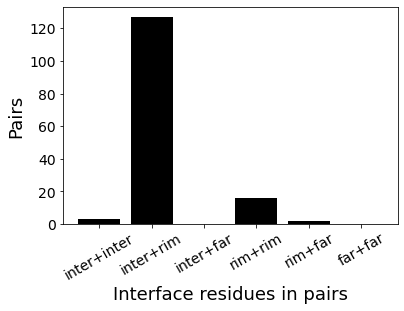

In [247]:
combi_counter=Counter()

for pair in indep_crosses_df[includes_cat].index:
    
    inter_1 = indep_crosses_df.at[pair, 'allele_1_interface']
    inter_2 = indep_crosses_df.at[pair, 'allele_2_interface']
    
    combi_counter[sum([inter_1, inter_2])] +=1
    
    
combi_counter

res_dict = {'inter+inter':2.0,
             'inter+rim':1.75,
             'inter+far':1.0,
             'rim+rim':1.5,
             'rim+far':0.75,
             'far+far':0.0}

for x in range(0,6):
    plt.bar(x, combi_counter[list(res_dict.values())[x]], color='k')
    
plt.xticks(range(0,6), res_dict.keys(), rotation=30, fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel('Interface residues in pairs', fontsize=18)
plt.ylabel('Pairs', fontsize=18)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa208364810>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa20836e0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa208364450>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa20836e990>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa20836edd0>,
 'means': []}

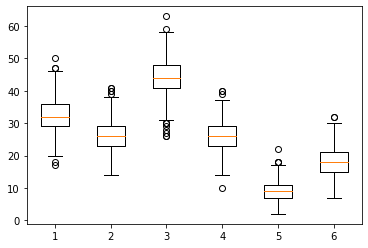

In [248]:
# make an empirical null distribution by sampling pairs of random LOF mutations

inter_iter_dict={1.0:[],
                 1.75:[],
                 0.75:[],
                 0.0:[],
                 2.0:[],
                 1.5:[]}
# container for distributions

for x in range(1,1000):
    random.seed(x)
    iter_dist = []
    iter_counter = Counter()
    # 1000 iterations
    
    for pair in frag_tuple_list:
        
        
        randomized_pair = draw_mutant_pair(pair)
        
        inter_1 = S_table_6_df.at[randomized_pair[0], 'interface']
        inter_2 = S_table_6_df.at[randomized_pair[1], 'interface']
        
        iter_counter[sum([inter_1, inter_2])] +=1
        
    for key in list(iter_counter.keys()):
        inter_iter_dict[key]+= [iter_counter[key]]
        


    

## Combine in one panel for Supp figure

Text(0, 0.5, 'Pairs')

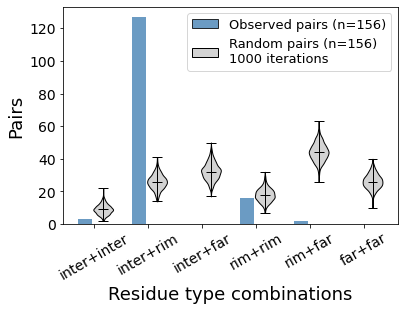

In [249]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


position=0



for x in range(0,6):
    inter_type = list(res_dict.values())[x]
    plt.bar(position, combi_counter[inter_type], color='steelblue', alpha=0.8)
    parts = plt.violinplot(inter_iter_dict[inter_type], positions=[position+1], widths=1.1, showmedians=True, showextrema=True)
    
    for pc in parts['bodies']:
        pc.set_facecolor('lightgrey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    for pc in ('cbars','cmins','cmaxes','cmedians'):
        vp = parts[pc]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)
    
    position+=3
    
plt.xticks([x+0.5 for x in range(0,18,3)], res_dict.keys(), rotation=30, fontsize=14)
plt.yticks(fontsize=14)


legend_elements = [Patch(facecolor='steelblue', edgecolor='k', label='Observed pairs (n=156)', alpha=0.8),
                   Patch(facecolor='lightgrey', edgecolor='k', label='Random pairs (n=156)\n1000 iterations')]



plt.legend(handles=legend_elements, fontsize=13)


plt.xlabel('Residue type combinations', fontsize=18)
plt.ylabel('Pairs', fontsize=18)

In [ ]:
indep_crosses_df.to_csv('../indep_crosses.csv', sep=',')
# save file for supp material